# Detecting cancer related genes in a disease-gene network using explainable AI

Welcome to this lecture on using explainable AI to identify and rank genes associated with cancer within a disease-gene network. Throughout this presentation, you will learn how to leverage Graph Neural Networks to prioritize genes based on their relationships with known genetic illnesses and risk factors. We will systematically cover four critical steps in this process:

1. **Constructing the Gene-Gene Relationship Graph**: We will begin by building a graph that maps the interactions between genes. This foundational step is crucial for later on training the GNN.

1. **Soft Label Propagation**: Given the inherent sparsity of genetic data, we will propagate labels and information through the network. 

1. **Developing the GraphSAGE GNN Network**: Using the enriched graph, we will create a GraphSAGE network. This type of neural network is designed to handle graph-structured data, allowing us to effectively learn and extract meaningful patterns from the genetic interactions.

1. **Employing Explainable AI for Gene Ranking**: Finally, we will utilize explainable AI techniques to identify the most significant subgraphs and nodes within our network. This analysis will help us rank genes based on their importance in classifying seed genes, providing insights into their potential roles in cancer.

# What is this lesson based on? 

This lecture is inspired by the publication ["XGDAG: Explainable Gene–Disease Associations via Graph Neural Networks"](https://doi.org/10.1093/bioinformatics/btad482). Much of the code and methodologies discussed can be accessed in the corresponding GitHub repository, allowing you to follow along and apply these techniques to your own data.


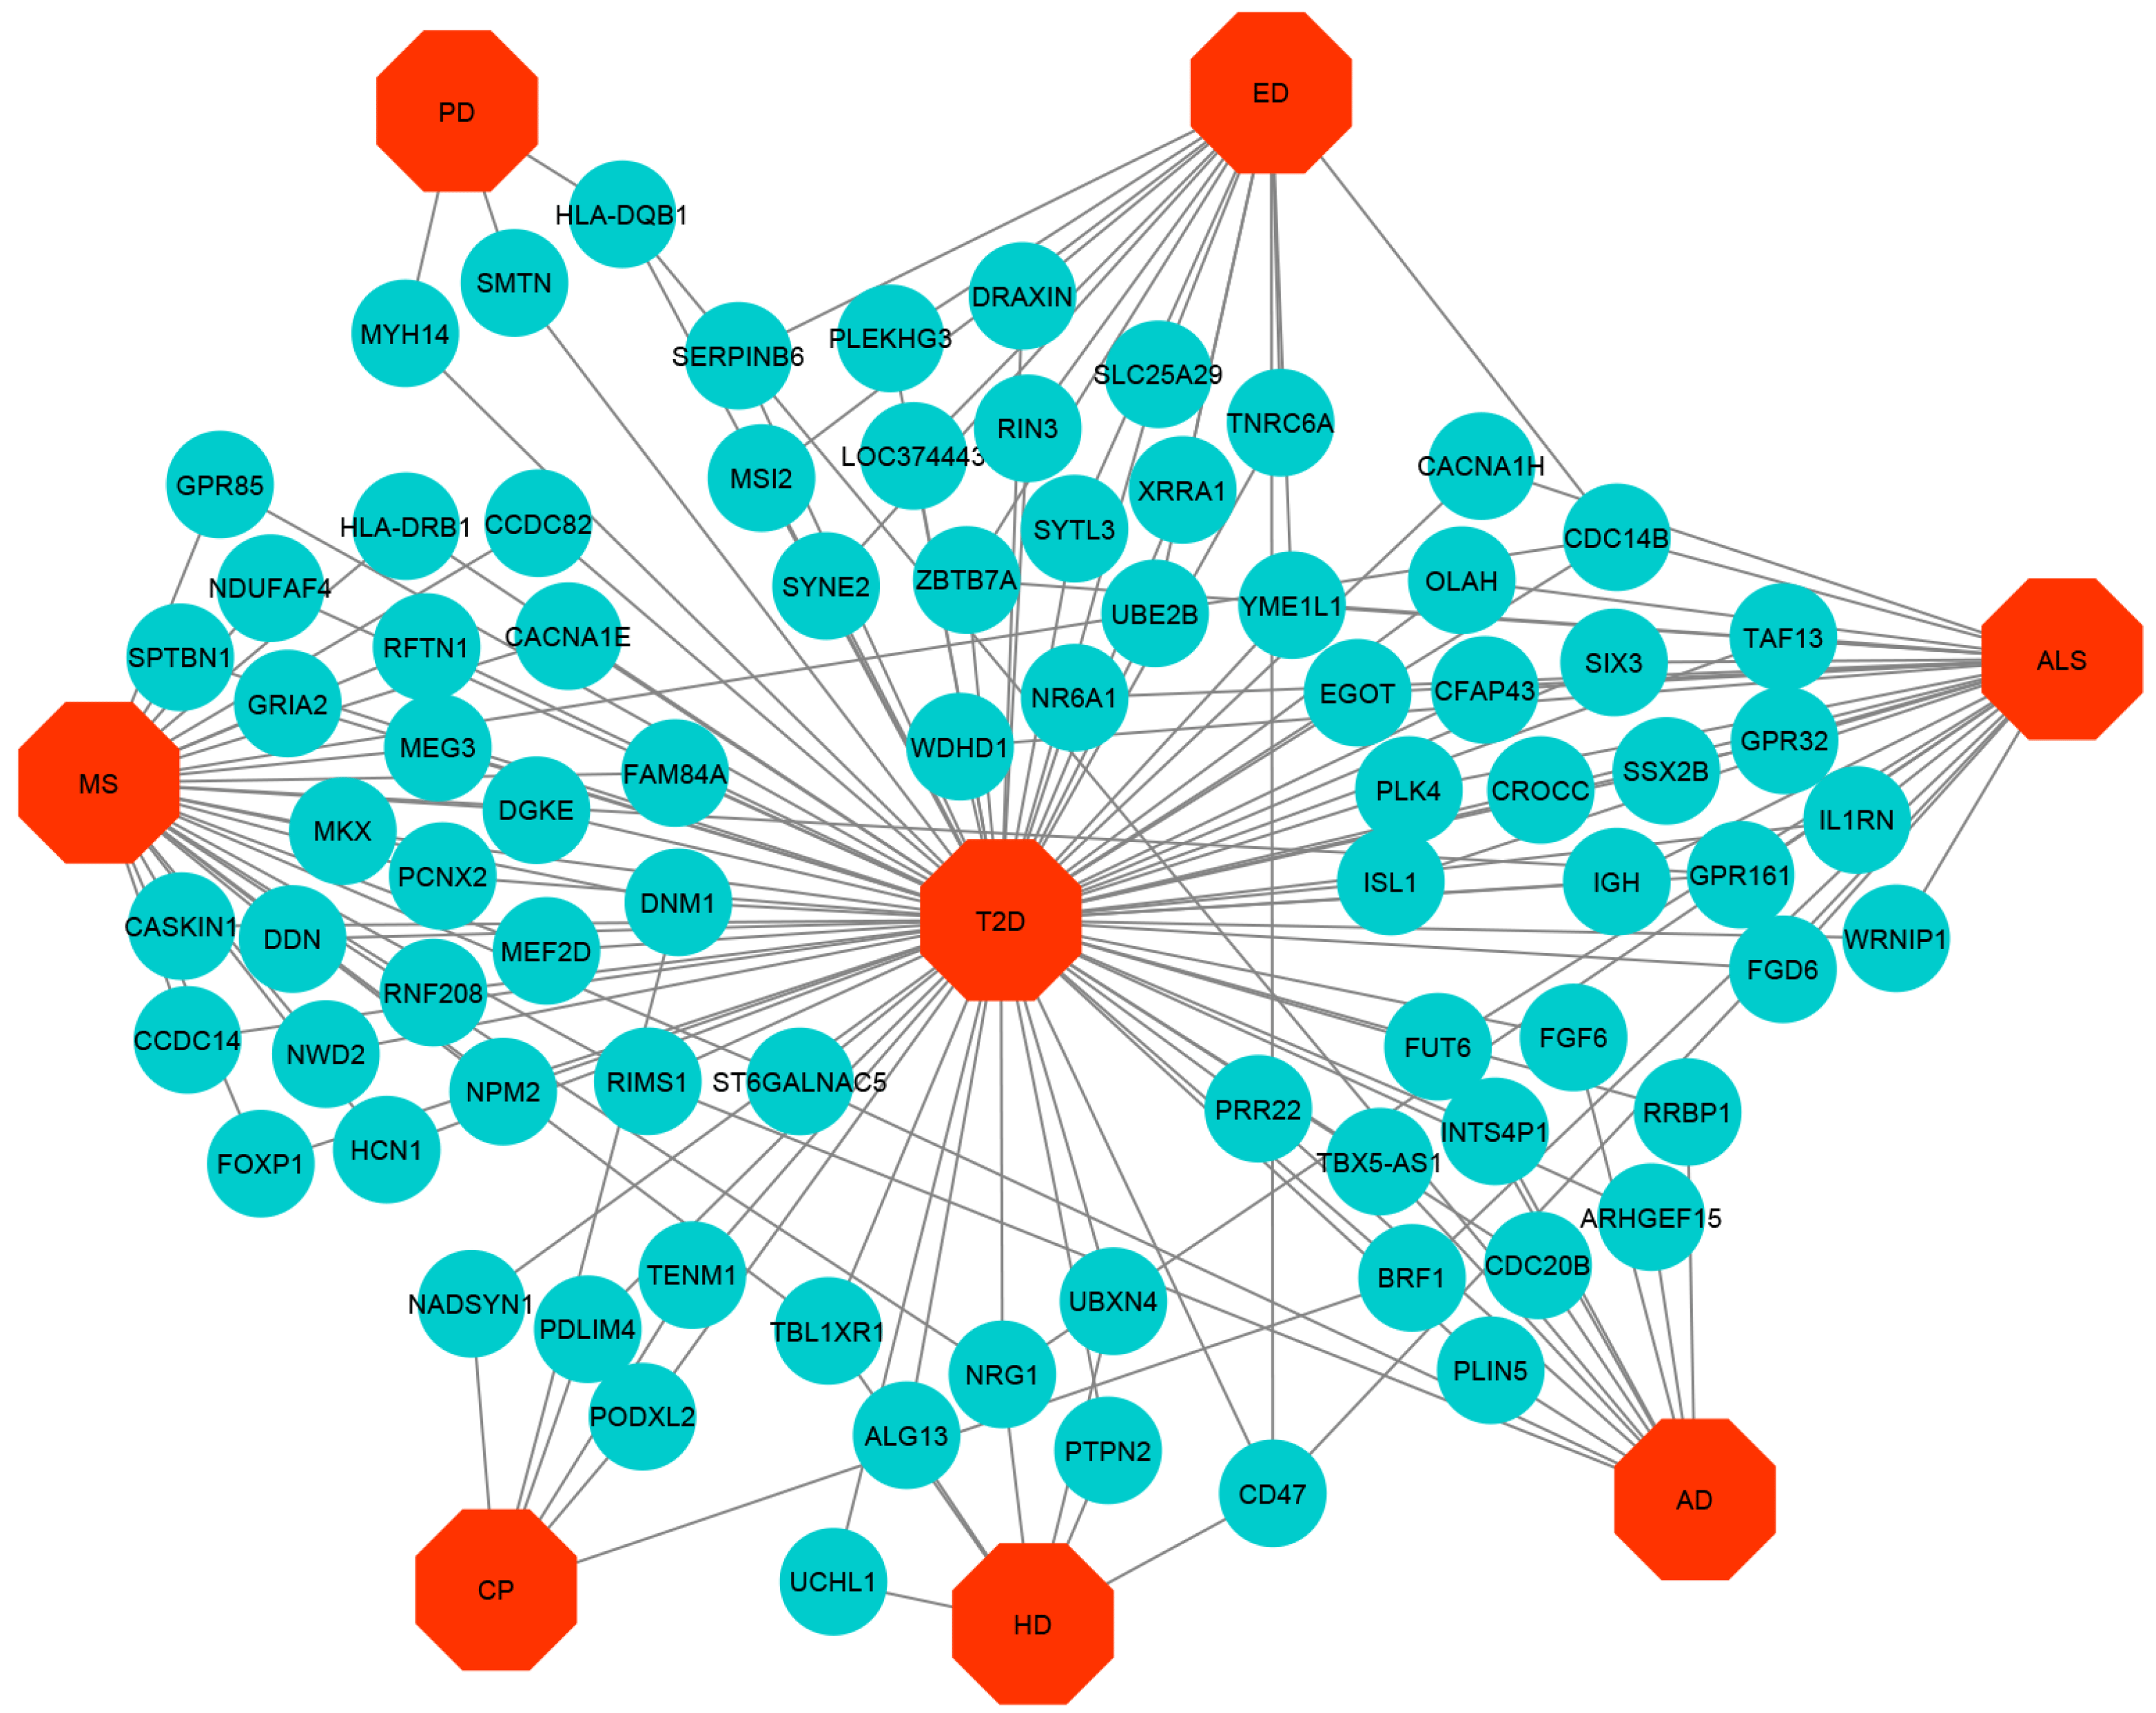

MS (Multiple Sclerosis), PD (Parkinson's Disease), ALS (Amyotrophic Lateral Sclerosis), T2D (Type 2 Diabetes), ED (Erectile Dysfunction), AD (Alzheimer's Disease), HD (Huntington's Disease), CP (Cerebral Palsy). More details: [A Network-Based Bioinformatics Approach to Identify Molecular Biomarkers for Type 2 Diabetes that Are Linked to the Progression of Neurological Diseases](https://pmc.ncbi.nlm.nih.gov/articles/PMC7037290/)


The XGDAG framework. A graph based on a PPI network and enriched with GDA information and node features is fed into a GNN. After the network has been trained, the predictions for the positive (P) genes are explained using an XAI methodology. Next, the nodes that appear in both the explanation subgraph and in the LP set are marked as candidate genes for prioritization

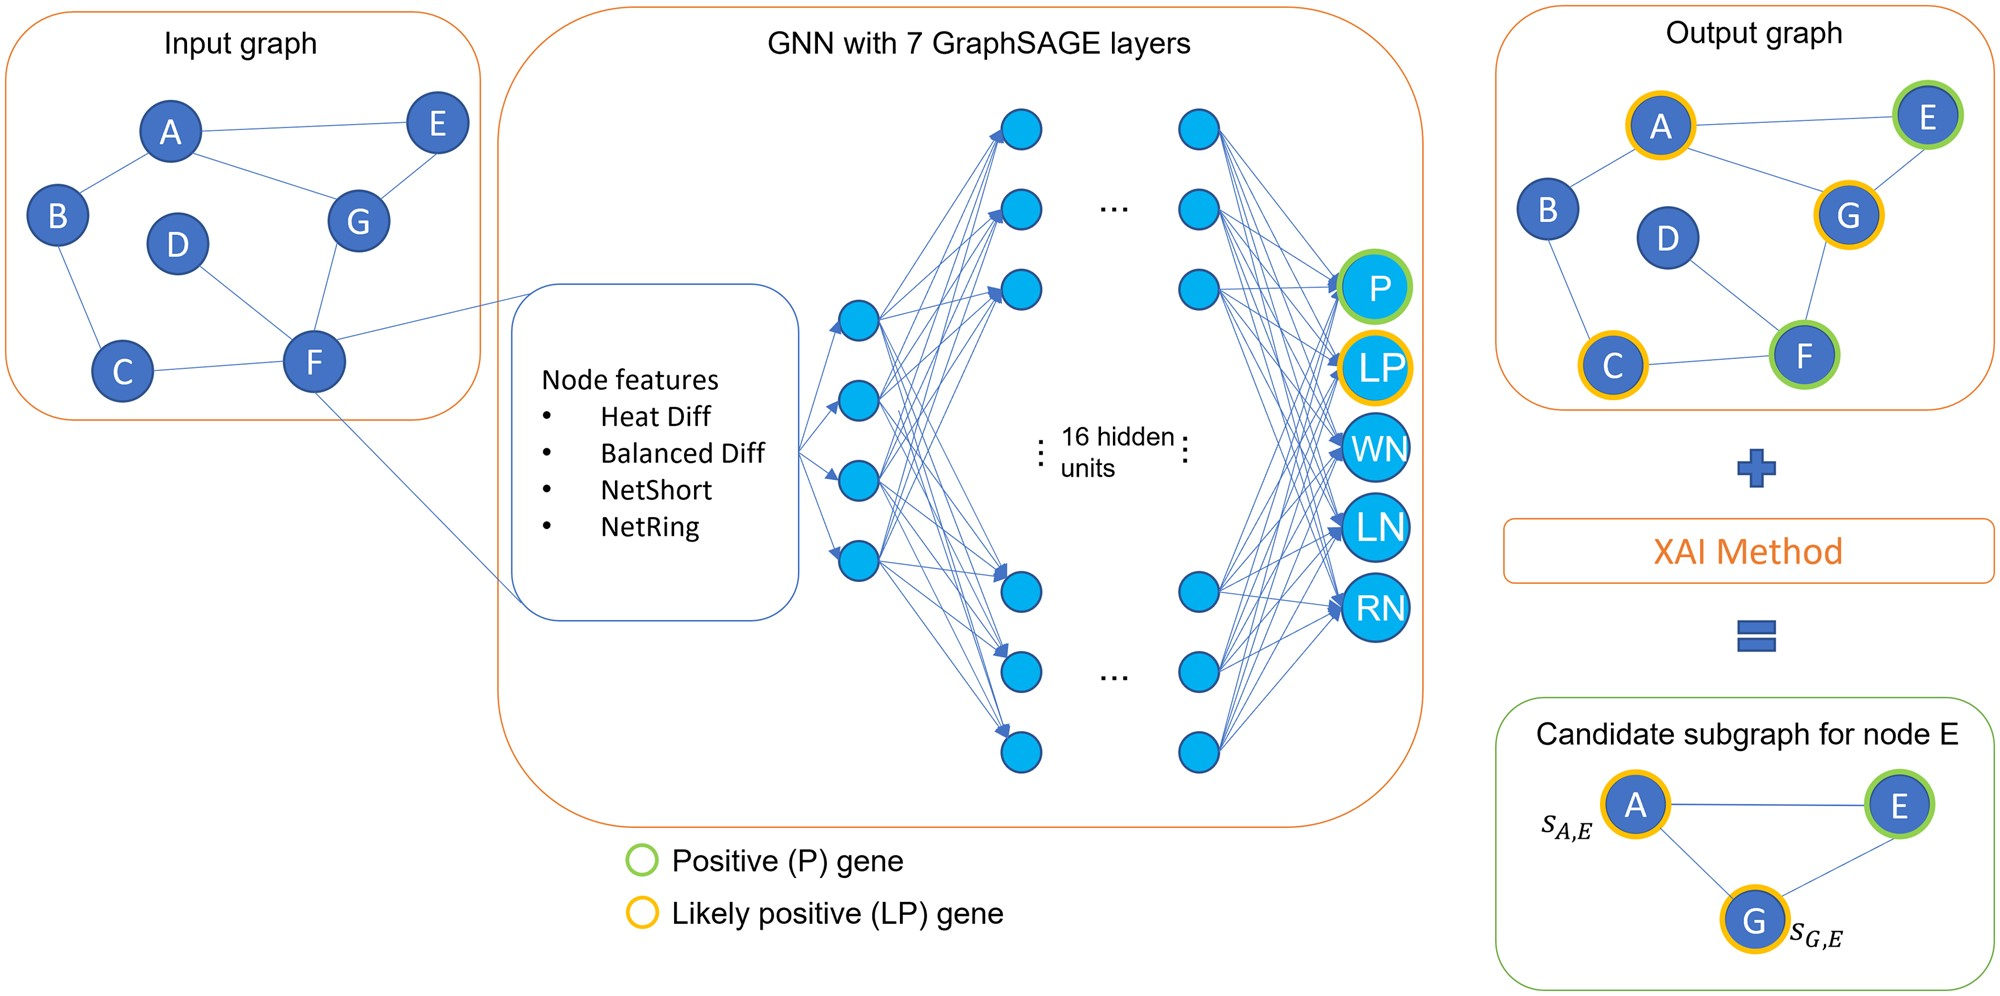

# Where are we getting our data from?

For this lesson we are getting data from two different sources:

1. https://thebiogrid.org/: BioGRID (Biological General Repository for Interaction Datasets) is a biomedical interaction repository. It archives and disseminates genetic and protein interaction data from model organisms and humans. It is widely used in the scientific community to study protein-protein interactions, genetic interactions, and chemical interactions, aiding in the understanding of cellular processes and disease mechanisms.
1. https://disgenet.com/: DisGeNET is a knowledge database that covers the full spectrum of human diseases. It is a comprehensive platform integrating information on gene-disease associations (GDAs) from various sources, including the scientific literature, curated databases, and genome-wide association studies (GWAS).

Let's have a look at the data we need.


In [1]:
PATH_TO_GRAPHS = "./data/Graphs/"
PATH_TO_DATASETS =  "./data/Datasets/"
MODEL_PATH = "./data/Models/model.pt"

In [2]:
import requests
biogrid_path = "https://downloads.thebiogrid.org/Download/BioGRID/Release-Archive/BIOGRID-4.4.206/BIOGRID-ALL-4.4.206.tab3.zip"
r = requests.get(biogrid_path, allow_redirects=True)
open('data/BIOGRID-ALL-4.4.206.tab3.zip', 'wb').write(r.content)

146505503

In [3]:
%%bash 
unzip data/BIOGRID-ALL-4.4.206.tab3.zip -d data/

Archive:  data/BIOGRID-ALL-4.4.206.tab3.zip
  inflating: data/BIOGRID-ALL-4.4.206.tab3.txt  


In [2]:
import pandas as pd

path_to_PPI = "./data/BIOGRID-ALL-4.4.206.tab3.txt"
biogrid = pd.read_csv(path_to_PPI, sep='\t', low_memory=False) # read the basic biogrid data

In [3]:
#### check out the columns and number of samples
print(biogrid.columns)

Index(['#BioGRID Interaction ID', 'Entrez Gene Interactor A',
       'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
       'BioGRID ID Interactor B', 'Systematic Name Interactor A',
       'Systematic Name Interactor B', 'Official Symbol Interactor A',
       'Official Symbol Interactor B', 'Synonyms Interactor A',
       'Synonyms Interactor B', 'Experimental System',
       'Experimental System Type', 'Author', 'Publication Source',
       'Organism ID Interactor A', 'Organism ID Interactor B', 'Throughput',
       'Score', 'Modification', 'Qualifications', 'Tags', 'Source Database',
       'SWISS-PROT Accessions Interactor A', 'TREMBL Accessions Interactor A',
       'REFSEQ Accessions Interactor A', 'SWISS-PROT Accessions Interactor B',
       'TREMBL Accessions Interactor B', 'REFSEQ Accessions Interactor B',
       'Ontology Term IDs', 'Ontology Term Names', 'Ontology Term Categories',
       'Ontology Term Qualifier IDs', 'Ontology Term Qualifier Names',
       'Ontology

In [4]:
biogrid

#BioGRID Interaction ID Entrez Gene Interactor A  \
0                            103                     6416   
1                            117                    84665   
2                            183                       90   
3                            278                     2624   
4                            418                     6118   
...                          ...                      ...   
2312693                  3310225                   126353   
2312694                  3310226                     5747   
2312695                  3310227                   126353   
2312696                  3310228                     1639   
2312697                  3310229                      472   

        Entrez Gene Interactor B  BioGRID ID Interactor A  \
0                           2318                   112315   
1                             88                   124185   
2                           2339                   106605   
3                           5371                   108894   
4                           6774                   112038   
...                          ...                      ...   
2312693                     5747                   125982   
2312694                   126353                   111719   
2312695                    22919                   125982   
2312696                   126353                   108007   
2312697                     7157                   106962   

         BioGRID ID Interactor B Systematic Name Interactor A  \
0                         108607                            -   
1                         106603                            -   
2                         108625                            -   
3                         111384                            -   
4                         112651                  RP4-547C9.3   
...                          ...                          ...   
2312693                   111719                            -   
2312694                   125982                            -   
2312695                   116581                            -   
2312696                   125982                            -   
2312697                   113010                            -   

        Systematic Name Interactor B Official Symbol Interactor A  \
0                                  -                       MAP2K4   
1                                  -                         MYPN   
2                                  -                        ACVR1   
3                                  -                        GATA2   
4                                  -                         RPA2   
...                              ...                          ...   
2312693                            -                         MISP   
2312694                            -                         PTK2   
2312695                            -                         MISP   
2312696                            -                        DCTN1   
2312697                            -                          ATM   

        Official Symbol Interactor B  \
0                               FLNC   
1                              ACTN2   
2                               FNTA   
3                                PML   
4                              STAT3   
...                              ...   
2312693                         PTK2   
2312694                         MISP   
2312695                       MAPRE1   
2312696                         MISP   
2312697                         TP53   

                                     Synonyms Interactor A  ...  \
0        JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...  ...   
1                                   CMD1DD|CMH22|MYOP|RCM4  ...   
2                  ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI  ...   
3                                 DCML|IMD21|MONOMAC|NFE1B  ...   
4                            REPA2|RP-A p32|RP-A p34|RPA32  ...   
...                                               

In [5]:
import numpy as np
print(np.unique(biogrid["Organism ID Interactor A"]))

[   3055    3702    3847    3988    4081    4098    4113    4558    4577
    6239    7227    7460    7955    8355    8839    9031    9103    9544
    9598    9606    9615    9823    9913    9940    9986   10029   10090
   10116   10141   10245   10298   10310   10335   10359   10376   10600
   10620   10621   10633   11103   11676   11709   11723   12242   13616
   29760   32603   32604   36329   37296   39947   60711   83332   83333
   88036  121224  171101  224308  227321  237561  237631  284812  316407
  333759  333760  333763  333923  347515  352472  367110  511145  559292
  595496  694009 1335626 2697049]


## What do those IDs mean?

Biogrids "Organism Interactor IDs" show us which organism a protein belongs to. Since we want to work with human cancer, we simply select only rows with a human ID (9606).

In [6]:
# Filtering non-human proteins
biogrid = biogrid[(biogrid['Organism ID Interactor A'] == 9606) & (biogrid['Organism ID Interactor B'] == 9606)]

In [7]:
# let's see how much data we have left
print(len(biogrid))

913180


In [8]:
# so what does this data shows us?
print(biogrid["Official Symbol Interactor A"].loc[0:10])
print(biogrid["Official Symbol Interactor B"].loc[0:10])

# biogrid shows us a network of interacting genes


0     MAP2K4
1       MYPN
2      ACVR1
3      GATA2
4       RPA2
5       ARF1
6       ARF3
7       ARF3
8       XRN1
9        APP
10     APLP1
Name: Official Symbol Interactor A, dtype: object
0       FLNC
1      ACTN2
2       FNTA
3        PML
4      STAT3
5       GGA3
6     ARFIP2
7     ARFIP1
8      ALDOA
9     APPBP2
10      DAB1
Name: Official Symbol Interactor B, dtype: object


## How does Biogrid decide which interactions to include?

1. **Experimental Evidence:** Interactions must be supported by experimental data. This includes results from various experimental techniques such as co-immunoprecipitation, mass spectrometry, and more.

1. **Curated from Literature:** BioGRID relies on manual curation from the primary scientific literature. Curators review published papers to extract interaction data.

1. **Biological Relevance:** Interactions must have biological significance. This includes relevance to cellular processes, pathways, or disease mechanisms.


**We now have enough information to build a very basic graph!**


In [9]:
import networkx as nx

G = nx.Graph()

for index, row in biogrid.iterrows():
    p1 = row['Official Symbol Interactor A'].replace('-', '_').replace('.', '_')
    p2 = row['Official Symbol Interactor B'].replace('-', '_').replace('.', '_')
    G.add_edge(p1, p2)

print('[+] Added', len(list(G.nodes)), 'nodes')
print('[+] Added', len(list(G.edges)), 'edges')

"""
We decide to remove all self-referential relationships from the graph, since we are looking for relationships
of cancer genes with other genes
"""

print('[-] Removing self loops...', end='')
G.remove_edges_from(nx.selfloop_edges(G))

print('\n[+] Total', len(list(G.edges)), 'edges')




[+] Added 19764 nodes
[+] Added 682198 edges
[-] Removing self loops...
[+] Total 678932 edges


In [10]:
"""
since the data inclues all protein-protein interactions, some subgraphs might be very sparse and not
connected with the majority. Let's check it out
"""
lcc = nx.connected_components(G)
print([len(sub) for sub in lcc])

"""
There is only very little data that is not properly connected to the rest, so we just throw it away:
"""
lcc = max(nx.connected_components(G), key=len)
G = G.subgraph(lcc).copy()

[19761, 1, 1, 1]


In [11]:
"""
We now only have to put everything together into a function that loads the biogrid data and a fucntion that
builds the basic graph.
"""


def load_data(path_to_PPI):
    
    print('[+] Reading PPI...', end='')
    biogrid = pd.read_csv(path_to_PPI, sep='\t', low_memory=False)
    biogrid = biogrid[(biogrid['Organism ID Interactor A'] == 9606) & (biogrid['Organism ID Interactor B'] == 9606)]
    return biogrid


"""
and a function to create and filter the graph as above:
"""

def create_graph(biogrid):
    
    print('[+] Creating the graph...', end='')
    G = nx.Graph()

    for index, row in biogrid.iterrows():
        p1 = row['Official Symbol Interactor A'].replace('-', '_').replace('.', '_')
        p2 = row['Official Symbol Interactor B'].replace('-', '_').replace('.', '_')
        G.add_edge(p1, p2)

    print('\t[+] Added', len(list(G.nodes)), 'nodes')
    print('\t[+] Added', len(list(G.edges)), 'edges')
    
    # Remove self loops
    print('[+] Removing self loops...', end='')
    G.remove_edges_from(nx.selfloop_edges(G))
    
    print('\t[+]', len(list(G.nodes)), 'nodes')
    print('\t[+]', len(list(G.edges)), 'edges')

    # Let's tale only the largest connected component
    print('[+] Taking the LCC...', end='')
    lcc = max(nx.connected_components(G), key=len)
    G = G.subgraph(lcc).copy()

    print('\t[+]', len(list(G.nodes)), 'nodes')
    print('\t[+]', len(list(G.edges)), 'edges')

    return G


## What is still missing?

We do now have an overview over how different proteins can interact within humans and constructed a graph based on it. But we still don't know any properties of our nodes. This is why we will make use of DISGENET.

DISGENET https://disgenet.com/ gives us insight into different diseases and which genes are likely related to it.

We can for example search for the ID "C0023896" and find genetic data related to alcoholic liver disease!

We can also search for cancer and receive information that is relevant for us. Currently we want to investigate specific cancer IDs:

1. C0006142: Malignant neoplasm of breast (breast cancer)

Here we are looking for genes we can use as "seed genes". So genes we know to be highly related to the disease in some manner, that we can use as a "starting point" for our network analysis. The data we are using here as features is preprocessed using NIAPU, we will explain that later on. Let's have a look at the data again.


## What is malignant neoplasm of breast (breast cancer)?


Breast cancer is a disease in which cells in the breast grow uncontrollably, forming a malignant tumor. These abnormal cells can invade surrounding breast tissue and can potentially spread (metastasize) to other parts of the body, such as the lymph nodes, bones, liver, or lungs.

### DISGENET: Gene disease associations for C0006142: Malignant neoplasm of breast (breast cancer)
![disease_net.png](figures/disease_net.png)

In [12]:
feature_path = "./data/Datasets/C0006142_features.txt"

print('Reading disease features', end='')
nedbit_features = pd.read_csv(feature_path, sep=",")

## check out the columns
nedbit_features

Reading disease features

name  class  degree  ring   NetRank   NetShort      HeatDiff  \
0            MAP2K4      1      52     1  0.377622  6621.1350  7.857457e-01   
1              FLNC      0     149     2  1.904549  6874.4400  5.550523e-02   
2             SPAG9      0     143     2  1.921519  7236.6560  2.945290e-02   
3             MAPK8      0     206     2  1.857275  7066.6730  6.140730e-02   
4            MAP4K2      0      93     2  1.952829  4421.7600  1.215995e-02   
...             ...    ...     ...   ...       ...        ...           ...   
19756         POTEH      0       1     3  2.894529   250.7687  4.536291e-05   
19757  LOC100996747      0       1     3  2.932798   252.9656  1.080252e-05   
19758        SPDYE3      0       1     4  3.935718   135.5872  1.485083e-06   
19759        OR2T12      0       1     4  3.984835   134.2648  7.934609e-07   
19760       TMEM158      0       1     3  2.966548   250.7963  2.696486e-05   

           InfoDiff  
0      8.043124e-01  
1      5.931604e-02  
2      4.752711e-02  
3      9.853601e-02  
4      2.699857e-02  
...             ...  
19756  1.512001e-05  
19757  2.030529e-04  
19758  3.824091e-06  
19759  1.608364e-07  
19760  8.144208e-05  

[19761 rows x 8 columns]

### What does this information mean?


The features of each disease is related to it's functionality in the graph:

1. **name**: Name of the gene or protein.
1. **class**: Type of the gene (positive or unknown).
1. **degree**: Degree of a node
1. **ring**: Introduces a concept of ring structures around seed nodes, calculating the gene's importance based on its proximity and connectivity to seed nodes. Starting from each seed node, the network expands outward in layers or rings, with each ring containing nodes a specific distance (usually by shortest path or edge count) from the seed node. The connectivity or interaction density of each node within each ring is evaluated. Genes closer in the ring structure to the seed nodes often hold higher potential functional importance, as they are more immediately linked within the network. The importance score of each gene is derived based on both proximity (how close it is to the seed node) and connectivity (how many direct or indirect connections it shares with the seed node or nodes in its ring).
1. **NetRank**: NetRank is a network-based ranking method that calculates the importance of nodes based on their connections to seed nodes (disease-associated nodes). It assesses the importance of a node by considering both the number and quality of its connections. In biological networks, genes or proteins with higher connectivity to disease nodes receive a higher NetRank.
1. **NetShort**: Measures the importance of a node based on how many seed nodes must be traversed to reach it. It is derived from the shortest path lengths in the network.
1. **HeatDiff**: Diffusion-based score related to heat diffusion processes in network analysis. HeatDiff uses the concept of heat diffusion, where "heat" spreads from seed nodes to other nodes in the network, simulating the flow of influence or functional proximity. This feature assigns each node a score based on how much "heat" it receives from disease-associated nodes. Heat diffusion considers both direct and indirect paths to seed nodes, with nodes closer to seed nodes or with more paths from them receiving higher heat values.
1. **InfoDiff**: "Information Diffusion" how information propagate through the network starting from this gene. InfoDiff is an information propagation approach that evaluates the flow of biological "information" (like genetic or proteomic interactions) from disease nodes to other nodes in the network. Like heat diffusion, InfoDiff assesses how information (rather than heat) diffuses through the network. It often relies on graph-theoretical models of information flow, considering both the quality and quantity of information pathways from seed nodes.

More details: [NIAPU: network-informed adaptive positive-unlabeled learning for disease gene identification](https://doi.org/10.1093/bioinformatics/btac848)
    

Now let's add it to each node.

In [13]:
degree      = dict(zip(nedbit_features['name'], nedbit_features['degree']))
ring        = dict(zip(nedbit_features['name'], nedbit_features['ring']))
NetRank     = dict(zip(nedbit_features['name'], nedbit_features['NetRank']))
NetShort    = dict(zip(nedbit_features['name'], nedbit_features['NetShort']))
HeatDiff    = dict(zip(nedbit_features['name'], nedbit_features['HeatDiff']))
InfoDiff    = dict(zip(nedbit_features['name'], nedbit_features['InfoDiff']))

len(degree), len(ring)

(19761, 19761)

In [14]:
delete = []
"""
Not every node we find in our nedbit_features we find in our graph, so we will delete unrelated nodes.

"""

for node in G:

    if node not in degree.keys(): 
        delete.append(node)
        continue

    G.nodes[node]['degree']    = degree[node]
    G.nodes[node]['ring']      = ring[node]
    G.nodes[node]['NetRank']   = NetRank[node]
    G.nodes[node]['NetShort']  = NetShort[node]
    G.nodes[node]['HeatDiff']  = HeatDiff[node]
    G.nodes[node]['InfoDiff']  = InfoDiff[node]

for node in delete:
    G.remove_node(node)

G.size(), len(G.edges()), len(G.nodes())

(678932, 678932, 19761)

In [15]:
"""
again we can put everything together into one hand function

"""


def add_node_features(G, disease_id):


    print('[+] Adding NeDBIT features...', end='')
    nedbit_features = pd.read_csv(PATH_TO_DATASETS + disease_id + '_features.txt')

    degree      = dict(zip(nedbit_features['name'], nedbit_features['degree']))
    ring        = dict(zip(nedbit_features['name'], nedbit_features['ring']))
    NetRank     = dict(zip(nedbit_features['name'], nedbit_features['NetRank']))
    NetShort    = dict(zip(nedbit_features['name'], nedbit_features['NetShort']))
    HeatDiff    = dict(zip(nedbit_features['name'], nedbit_features['HeatDiff']))
    InfoDiff    = dict(zip(nedbit_features['name'], nedbit_features['InfoDiff']))
    
    delete = []
    for node in G:
        if node not in degree.keys(): 
            delete.append(node)
            continue
        G.nodes[node]['degree']    = degree[node]
        G.nodes[node]['ring']      = ring[node]
        G.nodes[node]['NetRank']   = NetRank[node]
        G.nodes[node]['NetShort']  = NetShort[node]
        G.nodes[node]['HeatDiff']  = HeatDiff[node]
        G.nodes[node]['InfoDiff']  = InfoDiff[node]

    for node in delete:
        G.remove_node(node)
        
    print("Adjusted Graph size: ", G.size(), len(G.edges()), len(G.nodes()))
    return G

### Data normalization

The only thing left to do, before we can put it all together is data normalization. Since we want to work with neural networks, large differences in the scale of the feature can make convergance much more difficult. Normalization improves:

1. **Comparability of Features:**: The features (e.g., degree, NetRank, NetShort, HeatDiff, InfoDiff) are  measured on different scales. Normalization ensures that these features are on a comparable scale, preventing any single feature from dominating the analysis due to its larger numerical range. By normalizing the data, we ensure that each feature contributes equally to the analysis, regardless of its original unit of measurement.

1. **Improved Performance of Machine Learning Algorithms**: Many machine learning algorithms, such as gradient descent-based methods (e.g., neural networks) are sensitive to the scale of the input data. Normalization helps in improving the convergence speed and overall performance of these algorithms.Normalization also ensures that all features contribute equally to the distance metrics used in algorithms, leading to more accurate and reliable models.

**So let's get going**


In [16]:
## first collect all the data


degree      = []
ring        = []
NetRank     = []
NetShort    = []
HeatDiff    = []
InfoDiff    = []

for node in G:

    degree.append(G.nodes[node]['degree'])
    ring.append(G.nodes[node]['ring'])
    NetRank.append(G.nodes[node]['NetRank'])
    NetShort.append(G.nodes[node]['NetShort'])
    HeatDiff.append(G.nodes[node]['HeatDiff'])
    InfoDiff.append(G.nodes[node]['InfoDiff'])

features = [degree, ring, NetRank, NetShort, HeatDiff, InfoDiff]

## What kind of scaling should we use here?

To make sure that our resulting data is not influenced greatly by outliers, we can use a RobustScaler


\begin{align}
x^{'} = (x-median(x))/IQR(x)
\end{align}


This scales the data using the median and interquartile range (calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of the feature values). This makes it robust to outliers in the data.



In [17]:
from sklearn.preprocessing import RobustScaler

# next scale the data


transformer = RobustScaler().fit(np.array(features))
features = transformer.transform(np.array(features))

# and replace the graph node information

i = 0
for node in G:
    G.nodes[node]['degree']    = features[0][i]
    G.nodes[node]['ring']      = features[1][i]
    G.nodes[node]['NetRank']   = features[2][i]
    G.nodes[node]['NetShort']  = features[3][i]
    G.nodes[node]['HeatDiff']  = features[4][i]
    G.nodes[node]['InfoDiff']  = features[5][i]
    i += 1


In [18]:
"""
now we can put it all together into one scale_graph function again.

"""

def scale_graph(G):
    print('[+] Normalizing NeDBIT features...', end='')
    degree      = []
    ring        = []
    NetRank     = []
    NetShort    = []
    HeatDiff    = []
    InfoDiff    = []

    for node in G:

        degree.append(G.nodes[node]['degree'])
        ring.append(G.nodes[node]['ring'])
        NetRank.append(G.nodes[node]['NetRank'])
        NetShort.append(G.nodes[node]['NetShort'])
        HeatDiff.append(G.nodes[node]['HeatDiff'])
        InfoDiff.append(G.nodes[node]['InfoDiff'])

    features = [degree, ring, NetRank, NetShort, HeatDiff, InfoDiff]

    transformer = RobustScaler().fit(np.array(features))
    features = transformer.transform(np.array(features))

    i = 0
    for node in G:
        G.nodes[node]['degree']    = features[0][i]
        G.nodes[node]['ring']      = features[1][i]
        G.nodes[node]['NetRank']   = features[2][i]
        G.nodes[node]['NetShort']  = features[3][i]
        G.nodes[node]['HeatDiff']  = features[4][i]
        G.nodes[node]['InfoDiff']  = features[5][i]
        i += 1

    return G

In [19]:
### now we can also finally save our graph


graph_name = "test_graph"

graph_path = PATH_TO_GRAPHS + graph_name + '.gml'
print('[+] Saving graph to path:', graph_path)
nx.write_gml(G, graph_path)



[+] Saving graph to path: ./data/Graphs/test_graph.gml


### Putting everything together

In the last step we only have to put our functions together to get our final data pre-processing pipeline.

In [20]:
def create_feature_graph(path_to_PPI, disease_id, graph_name, scale=True, from_diamond=False):

    biogrid = load_data(path_to_PPI)
    G = create_graph(biogrid)
    G = add_node_features(G, disease_id)
    print("in")

    if scale == True: 
        G = scale_graph(G)
    print(G.size(), len(G.edges()), len(G.nodes()))
    print("scaling done")
    graph_path = PATH_TO_GRAPHS + graph_name + '.gml'
    print('[+] Saving graph to path:', graph_path)
    nx.write_gml(G, graph_path)
       
    return graph_path

feature_graph_path = create_feature_graph("data/BIOGRID-ALL-4.4.206.tab3.txt", "C0006142", "feature_graph", True, False)

[+] Reading PPI...[+] Creating the graph...	[+] Added 19764 nodes
	[+] Added 682198 edges
[+] Removing self loops...	[+] 19764 nodes
	[+] 678932 edges
[+] Taking the LCC...	[+] 19761 nodes
	[+] 678932 edges
[+] Adding NeDBIT features...Adjusted Graph size:  678932 678932 19761
in
[+] Normalizing NeDBIT features...678932 678932 19761
scaling done
[+] Saving graph to path: ./data/Graphs/feature_graph.gml


In [21]:
## Read the updated Graph

G = nx.read_gml(feature_graph_path)

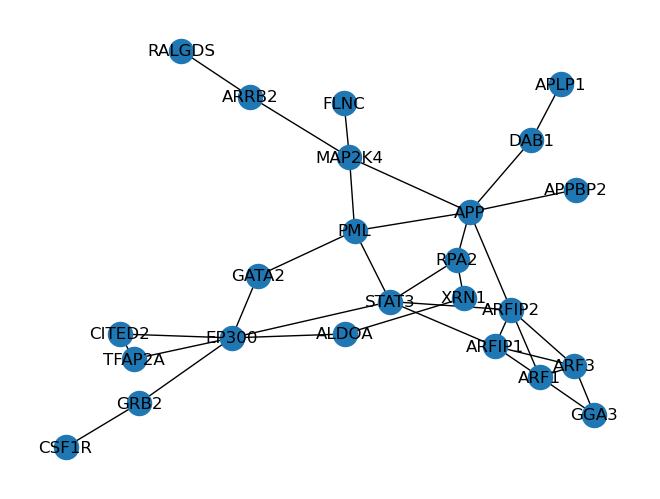

In [22]:
"""
We can also visualize a part of our graph to check out how it looks like. Here we select only 50 nodes, 
since otherwise we would not be able to see anything at all.

"""
import matplotlib.pyplot as plt

res = list(range(30))
new_nodes = []
for enum, n in enumerate(G.nodes(data=True)):
        
    if enum in res:
        if n[0] == "FNTA" or n[0] == "ACVR1" or n[0] == "MTTP" or n[0] == "APOB" \
        or n[0] == "MYPN" or n[0] == "ACTN2": continue
        new_nodes.append(n[0])
k = G.subgraph(new_nodes)
pos = nx.spring_layout(k)
nx.draw(k, pos=pos, with_labels = True)
plt.show()

# Using label propagation based on NIAPU

## Why do label propagation?

We now have some genes which we know to be associated with any disease. But what about the others? It would not make a lot of sense, to assume everything else to be part of the negative class, since we are trying to detect positive examples within this graph.

<blockquote>
<p>
Gene–disease associations are fundamental for understanding disease etiology and developing effective interventions and treatments. Identifying genes not yet associated with a disease due to a lack of studies is a
challenging task in which prioritization based on prior knowledge is an important element. The computational
search for new candidate disease genes may be eased by positive-unlabeled learning, the machine learning (ML)
setting in which only a subset of instances are labelled as positive while the rest of the dataset is unlabeled.
</p>
</blockquote>


## How do we do label propagation?

We are relying on NIAPU (Network-Informed Adaptive Positive-Unlabeled Learning) to do the hard lifting here. 


<blockquote>
<p>
In this work, we propose a set of effective network-based features to be used in a novel Markov diffusion-based multi-class labelling strategy for putative disease gene discovery. The performances of the new labelling algorithm and the effectiveness of the proposed features have been tested on 10 different disease datasets using three ML algorithms. The new features have been compared against classical topological and functional/ontological features and a set of network- and biological-derived features already used in gene discovery tasks. The predictive power of the integrated methodology in searching for new disease genes is competitive against state-of-the-art algorithms.
</p>
</blockquote>

The basic idea is that labels can be propagated using different versions of heat diffusion. The information we get from these different approaches is then aggregated into one particular score. From this score, we can then extract the different classes - positive (P), likely positive (LP), weakly negative (WN), likely negative (LN), and reliably negative (RN).


## How does NIAPU work exactly?

NIAPU he process begins by computing network diffusion and biology-informed topological (NeDBIT) features, such as heat diffusion and NetRing, to assess the importance of genes within a protein-protein interaction network. The algorithm initializes with seed genes (known positives) and selects reliable negatives (RN) based on their dissimilarity to seed genes. A Markov process with restart is employed to propagate labels through the network, iteratively updating probabilities until a stable state is achieved. Finally, genes are classified based on their ranks in the final state vector, and machine learning models like Random Forest, SVM or any classifier can be trained on the labelled data to enhance prediction accuracy. This adaptive approach ensures robust and accurate identification of disease-related genes, accommodating the complex nature of biological networks.

# Creating the dataset

In the next step we create the basic dataset we need to do inference later on.

In [23]:
## We read the seed genes created by NIAPU
disease_id = 'C0006142'
path = PATH_TO_DATASETS

path_to_seed_genes = path + disease_id + '_seed_genes.txt'
seed_genes = pd.read_csv(path_to_seed_genes, header=None, sep=' ')
seed_genes.columns  = ["name", "GDA Score"]
seeds_list          = seed_genes["name"].values.tolist()

In [24]:
## we also need the niapu scores

nedbit_scores = pd.read_csv(path + disease_id + '_ranking.txt', sep=' ', header=None)
nedbit_scores.columns = ["name", "out", "label"]
nedbit_scores

name       out  label
0            MAP2K4  0.840990      1
1              FLNC  0.004123      2
2             SPAG9  0.003430      2
3             MAPK8  0.007299      2
4            MAP4K2  0.000095      3
...             ...       ...    ...
19756         POTEH -0.012014      4
19757  LOC100996747 -0.219568      5
19758        SPDYE3 -0.218236      5
19759        OR2T12 -0.218167      5
19760       TMEM158 -0.219574      5

[19761 rows x 3 columns]

In [25]:
## load the labels in the order of the nodes of the Graph

nodes_labels = dict(zip(nedbit_scores['name'], nedbit_scores['label']))
labels = []
delete = []
for node in list(G.nodes):
    if node not in nodes_labels:
        delete.append(node)

for node in delete:
    G.remove_node(node)

for node in list(G.nodes):
    labels.append(nodes_labels[node]-1)
labels = np.asarray(labels)
print(len(labels))

19761


In [26]:
#### we define a wrapper for the dataset class, so we can iterate over it easier. Here we use the torch geometric memory class InMemoryDataset

from torch_geometric.data import InMemoryDataset
from torch_geometric.utils import from_networkx
from sklearn.model_selection import train_test_split
import torch


class MyDataset(InMemoryDataset):
  def __init__(self, G, labels, attributes, num_classes=2):
    super(MyDataset, self).__init__('.', None, None, None)

    # import data from the networkx graph with the attributes of the nodes
    data = from_networkx(G, attributes)
      
    y = torch.from_numpy(labels).type(torch.long)

    data.x = data.x.float()
    data.y = y.clone().detach()
    data.num_classes = num_classes

    # Using train_test_split function from sklearn to stratify train/test/val sets
    indices = range(G.number_of_nodes())
    # Stratified split of train/test/val sets. Returned indices are used to create the masks
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(data.x, data.y, indices, test_size=0.3, stratify=labels, random_state=42)
    # To create validation set, test set is splitted in half
    X_test, X_val, y_test, y_val, test_idx, val_idx = train_test_split(X_test, y_test, test_idx, test_size=0.5, stratify=y_test, random_state=42)

    n_nodes = G.number_of_nodes()
    train_mask  = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask   = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask    = torch.zeros(n_nodes, dtype=torch.bool)
    
    for idx in train_idx:
      train_mask[idx] = True

    for idx in test_idx:
      test_mask[idx] = True
    
    for idx in val_idx:
      val_mask[idx] = True

    data['train_mask']  = train_mask
    data['test_mask']   = test_mask
    data['val_mask']    = val_mask

    self.data, self.slices = self.collate([data])

In [27]:
attributes = ['degree', 'ring', 'NetRank', 'NetShort', 'HeatDiff', 'InfoDiff']
print(G.size(), len(G.nodes()), len(labels), len(attributes))
dataset_with_nedbit = MyDataset(G, labels, attributes, num_classes=5)
dataset = dataset_with_nedbit[0]
dataset

678932 19761 19761 6


Data(edge_index=[2, 1357864], x=[19761, 6], y=[19761], num_classes=5, train_mask=[19761], test_mask=[19761], val_mask=[19761])

In [28]:
dataset.x.shape, dataset.y.shape

(torch.Size([19761, 6]), torch.Size([19761]))

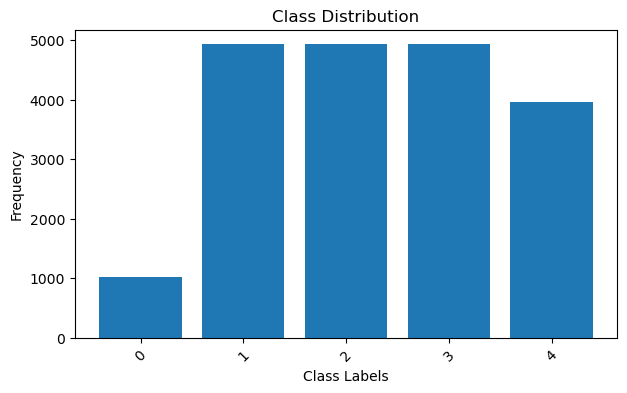

In [29]:
import matplotlib.pyplot as plt
from collections import Counter
"""
Let's check out the class distribution
"""
def plot_class_distribution(labels):
    counter = Counter(labels)
    classes = list(counter.keys())
    counts = list(counter.values())
    
    # Plotting the distribution
    plt.figure(figsize=(7, 4))
    plt.bar(classes, counts)
    plt.xlabel('Class Labels')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(labels)

### Calculating train weights

We can see above that only a minority of classes is positive (P). This might create issues later on, since we do want to explain the positive classes. Hence we might want to set training weights. Choosing undersampling/oversampling instead comes with additional complications, since we want to train on the whole graph.

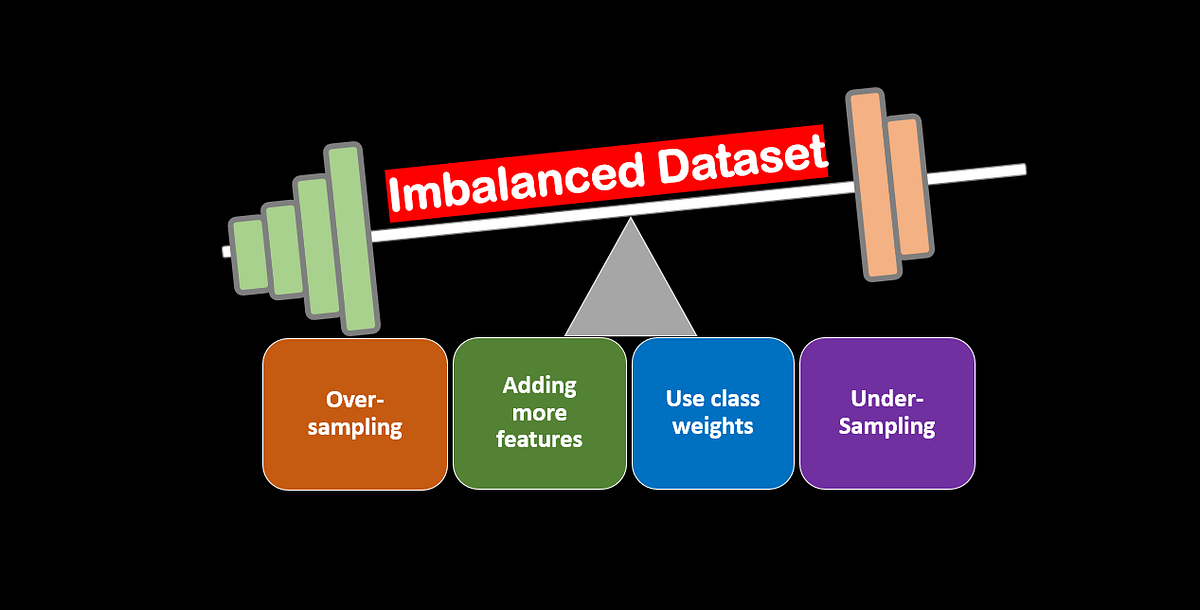


In [30]:
import numpy as np

def calculate_class_weights(labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    class_weights = {cls: total_samples / (len(unique_classes) * count) for cls, count in zip(unique_classes, class_counts)}
    return class_weights

path_to_graph = PATH_TO_GRAPHS + 'feature_graph.gml'
disease_id = 'C0006142'

train_mask  = dataset["train_mask"]
labels_masked = labels[train_mask]
weights = calculate_class_weights(labels_masked)
print(weights)

{0: 3.852924791086351, 1: 0.8018550724637681, 2: 0.8020875616120615, 3: 0.8020875616120615, 4: 1.0001446131597975}


In [31]:
#  Find the highest index
max_index = max(weights.keys())
# Fill in 0 if a key is missing
tensor_values = [weights.get(i, 0) for i in range(max_index + 1)]  
# Create a tensor from the list
wt_tensor = torch.tensor(tensor_values, dtype=torch.float)
wt_tensor

tensor([3.8529, 0.8019, 0.8021, 0.8021, 1.0001])

# Creating the classification model

We already learned about GraphCNNs and graph attention networks (GATs) in the lecture. Here we will introduce another possibility called GraphSage. The biggest differnce to previous models is the aggregation function GraphSage uses.




# GraphSage

GraphSAGE (Graph Sample and AggregatE) is a scalable and efficient Graph Neural Network (GNN) algorithm designed for inductive learning on large graphs. GraphSAGE generates embeddings for nodes by learning functions that aggregate and combine feature information from a node's local neighbourhood. The process involves sampling a fixed-size set of neighbours and applying various aggregation functions (e.g., mean, pooling) to produce node embeddings. This approach enables the model to generalize to new nodes dynamically added to the graph, making it particularly suitable for applications in social networks, recommendation systems, and biological networks.


| GraphConv | GraphSage |
| --- | --- |
| Typically operate in a transductive setting where the entire graph structure must be known during both training and inference. They compute node embeddings for the specific graph used in training and cannot naturally generalize to new nodes | Designed for inductive learning, allowing them to generate embeddings for unseen nodes in dynamic or evolving graphs. It learns a function that can be applied to any node based on its local neighbourhood, enabling the model to generalize to new nodes | 
| Often consider all neighbours of a node, leading to potential scalability issues as the size of the graph grows, especially with high-degree nodes causing computational and memory bottlenecks | Uses neighbour sampling to create fixed-size neighbourhoods for each node. This approach controls the computational complexity and memory usage by considering only a subset of neighbours, making it scalable to large graphs |
| Typically use a weighted sum or average of neighbouring node features, followed by a non-linear transformation, to aggregate information. The flexibility in choosing different aggregation strategies is limited compared to GraphSAGE | Employs various aggregation functions such as mean, and pooling to combine information from a node’s neighbours. These aggregators can capture different aspects of the local neighbourhood structure |
| Generally rely on the recursive neighbourhood aggregation without explicitly flexibly combining node-specific features. The propagation and update steps are often tightly coupled within the graph convolution operation | Combines the aggregated neighbourhood features with the node’s features and passes them through a neural network to update node embeddings iteratively. This method ensures that both local and node-specific information is considered in the embedding | 



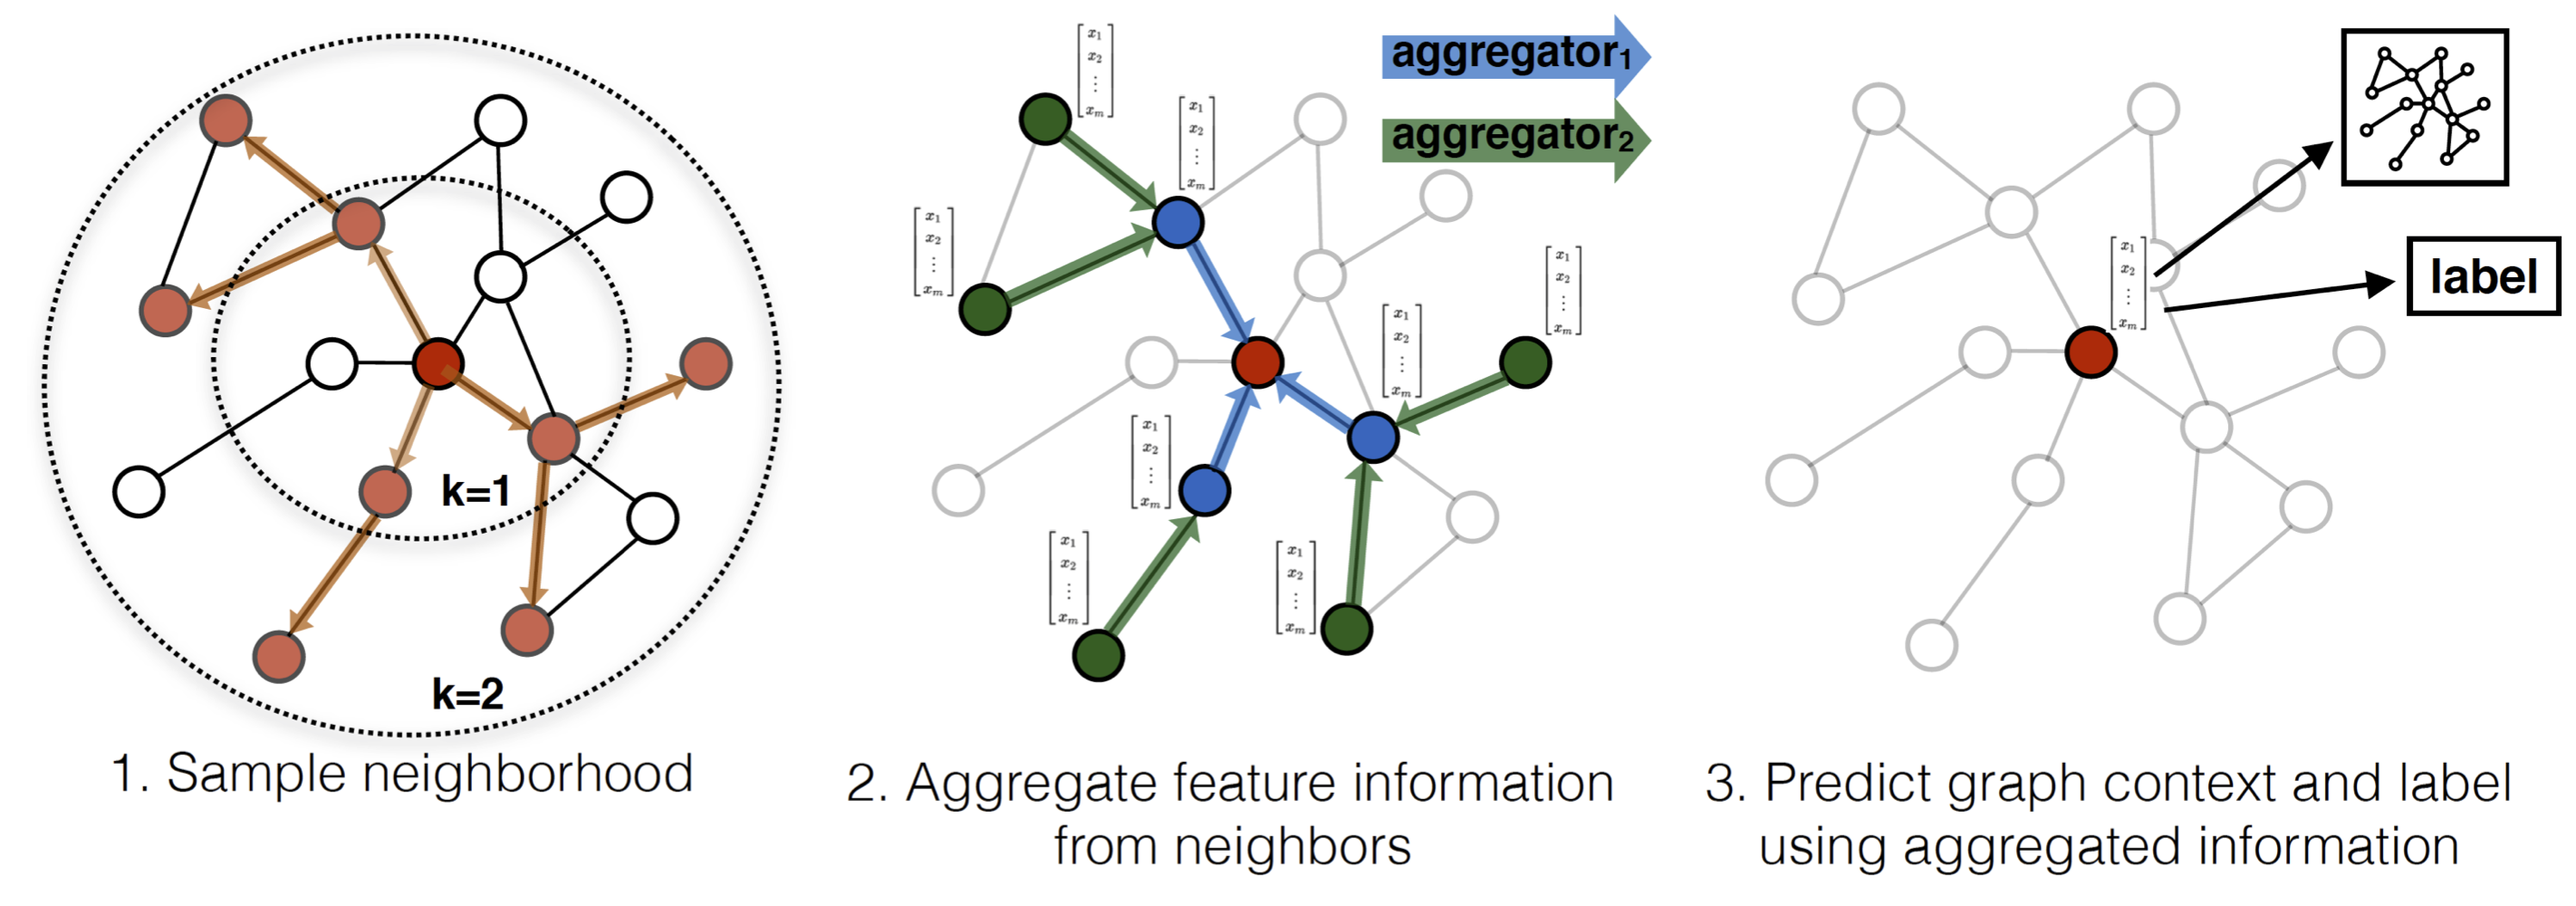






## Aggregator function

The aggregator function in GraphSAGE is a key component that determines how the features of a node's neighbors are combined to generate its new feature representation. There are several types of aggregation functions used in GraphSAGE, each with its unique approach to combining neighborhood information. All of them are based on the same basic function.

### Which aggregation function to choose?

Before we implement out GNN_Sage model we have to choose an aggregation function. 

1. Mean Aggregation: Simple, smooth way to aggregate features from neighboring nodes. Might result in the loss of some viable information about the graph's structure and node features.

1. Max Aggregation: Selects the most significant features from the neighborhood, which can highlight important aspects of the graph structure and node features. Unfortunately a lot of information ends up disregarded. 

Since **Max Aggregation** focuses on the maximum values it is easily disturbed by outliers and noise in the data. This is a problem we already took care of by making use of RobustScaling above.  


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import SAGEConv

class GNN2L_Sage (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, 16, aggr='max')
        self.conv2 = SAGEConv(16, int(data.num_classes), aggr='max')

    def forward(self, x=None, edge_index=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

class GNN7L_Sage (nn.Module):
    def __init__(self, data):
        super().__init__()
        self.conv1 = SAGEConv(data.num_features, 16)
        self.conv2 = SAGEConv(16, 16)
        self.conv3 = SAGEConv(16, 16)
        self.conv4 = SAGEConv(16, 16)
        self.conv5 = SAGEConv(16, 16)
        self.conv6 = SAGEConv(16, 16)
        self.conv7 = SAGEConv(16, int(data.num_classes))

    def forward(self, x=None, edge_index=None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = F.relu(self.conv6(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv7(x, edge_index)
        return F.log_softmax(x, dim=1)

### Training the network

Since we have already created the graphsage neural network and our dataset above, we can now concentrate on creating our training function. This is now very straight forward:


In [33]:
## if you have cuda installed you can make use of it by converting your model/tensor to cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
## set seed for training
torch.manual_seed(42)

### move data and model to cpu or cuda
wt_tensor = wt_tensor.to(device)
dataset = dataset.to(device)

cuda


## Early stopping to prevent overfitting

Early stopping is a regularization technique used to prevent overfitting in machine learning by halting the training process once the model's performance on a validation set stops improving. This is done by observing a specific metric (such as validation loss or accuracy) during training, and if no improvement is observed over a pre-defined number of epochs on the validation set, the training is stopped. This approach ensures that the model does not continue to learn noise and overfit to the training data, thereby maintaining better generalization to unseen data. Here we simply save the model that performs best on the validation set. This will also lead to us slightly overfitting to the validation set.

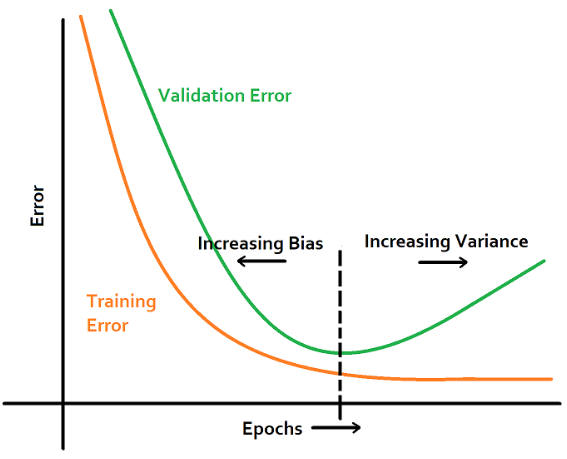


In [34]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn

# list to plot the train accuracy
train_acc_curve = []
train_lss_curve = []
val_acc_curve = []
val_lss_curve = []

def train(model, data, epochs = 200, classes = ['0','1'], lr = 0.001, weight_decay=0, cm_title = 'GNN', num_layers = 7):
    title = cm_title + '_' + str(epochs) + '_' + str(weight_decay).replace('.', '_')

    model_path  = './data/Models/' + title

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_mask  = data['train_mask']
    test_mask   = data['test_mask']
    val_mask    = data['val_mask']

    labels    = data.y
    output = ''

    best_train_acc  = 0
    best_val_acc    = 0
    best_train_lss  = 999
    best_loss_epoch = 0

    for e in tqdm(range(epochs+1)):
        model.train()
        optimizer.zero_grad()
        logits      = model(data.x, data.edge_index)
        output      = logits.argmax(1)
        train_loss  = F.nll_loss(logits[train_mask], labels[train_mask])
        train_acc   = (output[train_mask] == labels[train_mask]).float().mean()
        train_loss.backward()
        optimizer.step()

        if train_acc > best_train_acc:
            best_train_acc = train_acc

        # Evaluation and test
        model.eval()
        logits      = model(data.x, data.edge_index)
        output      = logits.argmax(1)
        val_loss    = F.nll_loss(logits[val_mask], labels[val_mask])
        val_acc     = (output[val_mask] == labels[val_mask]).float().mean()
        
        # Update best test/val acc.
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # Save model with best train loss
        if train_loss < best_train_lss:
            best_train_lss = train_loss
            best_loss_epoch = e
            torch.save(model.state_dict(), model_path)

        if e % 1000 == 0:
            # Append train acc. to plot curve later
            train_acc_curve.append(train_acc.item())
            train_lss_curve.append(train_loss.item())
            val_acc_curve.append(val_acc.item())
            val_lss_curve.append(val_loss.item())
            print('[Epoch: {:04d}]'.format(e),
            'train loss: {:.4f},'.format(train_loss.item()),
            'train acc: {:.4f},'.format(train_acc.item()),
            'val loss: {:.4f},'.format(val_loss.item()),
            'val acc: {:.4f} '.format(val_acc.item()),
            '(best train acc: {:.4f},'.format(best_train_acc.item()),
            'best val acc: {:.4f},'.format(best_val_acc.item()),
            'best train loss: {:.4f} '.format(best_train_lss),
            '@ epoch', best_loss_epoch ,')')
    
    return model

In [35]:
gnn_sage = GNN7L_Sage(dataset).to(device)
trained_model = train(gnn_sage, dataset.to(device), 40000, classes=['P', 'LP', 'WN', 'LN', 'RN'], weight_decay=0.0005, cm_title='SAGE7L_multiclass_16HC_v2')

  0%|                                                                                                                                                                    | 7/40001 [00:00<28:51, 23.10it/s]

[Epoch: 0000] train loss: 2.1378, train acc: 0.2640, val loss: 1.9093, val acc: 0.2772  (best train acc: 0.2640, best val acc: 0.2772, best train loss: 2.1378  @ epoch 0 )


  3%|████                                                                                                                                                             | 1013/40001 [00:15<09:40, 67.19it/s]

[Epoch: 1000] train loss: 0.9382, train acc: 0.5799, val loss: 0.8823, val acc: 0.6118  (best train acc: 0.5910, best val acc: 0.6182, best train loss: 0.9310  @ epoch 998 )


  5%|████████                                                                                                                                                         | 2014/40001 [00:30<09:16, 68.28it/s]

[Epoch: 2000] train loss: 0.8546, train acc: 0.6241, val loss: 0.8614, val acc: 0.6111  (best train acc: 0.6345, best val acc: 0.6648, best train loss: 0.8350  @ epoch 1997 )


  8%|████████████                                                                                                                                                     | 3008/40001 [00:44<08:58, 68.65it/s]

[Epoch: 3000] train loss: 0.7935, train acc: 0.6495, val loss: 0.8000, val acc: 0.6944  (best train acc: 0.6578, best val acc: 0.6985, best train loss: 0.7795  @ epoch 2844 )


 10%|████████████████▏                                                                                                                                                | 4009/40001 [00:59<08:54, 67.28it/s]

[Epoch: 4000] train loss: 0.6543, train acc: 0.7151, val loss: 0.6920, val acc: 0.7889  (best train acc: 0.7410, best val acc: 0.8108, best train loss: 0.6212  @ epoch 3999 )


 13%|████████████████████▏                                                                                                                                            | 5010/40001 [01:14<08:31, 68.47it/s]

[Epoch: 5000] train loss: 0.7655, train acc: 0.6416, val loss: 0.7938, val acc: 0.7558  (best train acc: 0.8112, best val acc: 0.8691, best train loss: 0.4655  @ epoch 4958 )


 15%|████████████████████████▏                                                                                                                                        | 6011/40001 [01:28<08:16, 68.51it/s]

[Epoch: 6000] train loss: 0.4343, train acc: 0.8229, val loss: 0.6434, val acc: 0.8513  (best train acc: 0.8394, best val acc: 0.8870, best train loss: 0.4032  @ epoch 5934 )


 18%|████████████████████████████▏                                                                                                                                    | 7012/40001 [01:43<08:05, 67.91it/s]

[Epoch: 7000] train loss: 0.3868, train acc: 0.8467, val loss: 0.5581, val acc: 0.8927  (best train acc: 0.8527, best val acc: 0.9008, best train loss: 0.3759  @ epoch 6952 )


 20%|████████████████████████████████▎                                                                                                                                | 8013/40001 [01:58<07:50, 67.95it/s]

[Epoch: 8000] train loss: 0.3768, train acc: 0.8509, val loss: 0.5687, val acc: 0.8735  (best train acc: 0.8597, best val acc: 0.9052, best train loss: 0.3555  @ epoch 7838 )


 23%|████████████████████████████████████▎                                                                                                                            | 9014/40001 [02:12<07:41, 67.11it/s]

[Epoch: 9000] train loss: 0.3804, train acc: 0.8462, val loss: 0.5179, val acc: 0.8978  (best train acc: 0.8683, best val acc: 0.9099, best train loss: 0.3362  @ epoch 8778 )


 25%|████████████████████████████████████████                                                                                                                        | 10008/40001 [02:27<07:21, 67.95it/s]

[Epoch: 10000] train loss: 0.3403, train acc: 0.8642, val loss: 0.5125, val acc: 0.9099  (best train acc: 0.8725, best val acc: 0.9153, best train loss: 0.3241  @ epoch 9812 )


 28%|████████████████████████████████████████████                                                                                                                    | 11009/40001 [02:42<07:07, 67.87it/s]

[Epoch: 11000] train loss: 0.3206, train acc: 0.8735, val loss: 0.5245, val acc: 0.9069  (best train acc: 0.8815, best val acc: 0.9194, best train loss: 0.3145  @ epoch 10853 )


 30%|████████████████████████████████████████████████                                                                                                                | 12010/40001 [02:56<06:50, 68.12it/s]

[Epoch: 12000] train loss: 0.3145, train acc: 0.8761, val loss: 0.5167, val acc: 0.9160  (best train acc: 0.8847, best val acc: 0.9218, best train loss: 0.2976  @ epoch 11421 )


 33%|████████████████████████████████████████████████████                                                                                                            | 13011/40001 [03:11<06:36, 68.14it/s]

[Epoch: 13000] train loss: 0.3169, train acc: 0.8742, val loss: 0.5220, val acc: 0.9106  (best train acc: 0.8892, best val acc: 0.9248, best train loss: 0.2861  @ epoch 12847 )


 35%|████████████████████████████████████████████████████████                                                                                                        | 14012/40001 [03:26<06:22, 68.00it/s]

[Epoch: 14000] train loss: 0.3632, train acc: 0.8504, val loss: 0.5536, val acc: 0.9079  (best train acc: 0.8920, best val acc: 0.9282, best train loss: 0.2790  @ epoch 13555 )


 38%|████████████████████████████████████████████████████████████                                                                                                    | 15013/40001 [03:41<06:07, 68.03it/s]

[Epoch: 15000] train loss: 0.2953, train acc: 0.8862, val loss: 0.5157, val acc: 0.9164  (best train acc: 0.8955, best val acc: 0.9322, best train loss: 0.2728  @ epoch 14978 )


 40%|████████████████████████████████████████████████████████████████                                                                                                | 16014/40001 [03:55<05:52, 68.08it/s]

[Epoch: 16000] train loss: 0.3006, train acc: 0.8814, val loss: 0.5067, val acc: 0.9130  (best train acc: 0.9010, best val acc: 0.9325, best train loss: 0.2616  @ epoch 15911 )


 43%|████████████████████████████████████████████████████████████████████                                                                                            | 17008/40001 [04:10<05:35, 68.62it/s]

[Epoch: 17000] train loss: 0.3573, train acc: 0.8584, val loss: 0.5911, val acc: 0.9194  (best train acc: 0.9010, best val acc: 0.9325, best train loss: 0.2616  @ epoch 15911 )


 45%|████████████████████████████████████████████████████████████████████████                                                                                        | 18009/40001 [04:24<05:20, 68.57it/s]

[Epoch: 18000] train loss: 0.2994, train acc: 0.8857, val loss: 0.4824, val acc: 0.9214  (best train acc: 0.9010, best val acc: 0.9325, best train loss: 0.2616  @ epoch 15911 )


 48%|████████████████████████████████████████████████████████████████████████████                                                                                    | 19010/40001 [04:39<05:06, 68.59it/s]

[Epoch: 19000] train loss: 0.6763, train acc: 0.6914, val loss: 0.8068, val acc: 0.7794  (best train acc: 0.9046, best val acc: 0.9325, best train loss: 0.2507  @ epoch 18919 )


 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 20011/40001 [04:54<04:51, 68.64it/s]

[Epoch: 20000] train loss: 0.2983, train acc: 0.8837, val loss: 0.4705, val acc: 0.9265  (best train acc: 0.9065, best val acc: 0.9342, best train loss: 0.2454  @ epoch 19716 )


 53%|████████████████████████████████████████████████████████████████████████████████████                                                                            | 21012/40001 [05:08<04:37, 68.48it/s]

[Epoch: 21000] train loss: 0.2593, train acc: 0.9036, val loss: 0.4844, val acc: 0.9234  (best train acc: 0.9088, best val acc: 0.9342, best train loss: 0.2406  @ epoch 20239 )


 55%|████████████████████████████████████████████████████████████████████████████████████████                                                                        | 22013/40001 [05:23<04:23, 68.38it/s]

[Epoch: 22000] train loss: 0.3130, train acc: 0.8793, val loss: 0.4620, val acc: 0.9241  (best train acc: 0.9100, best val acc: 0.9359, best train loss: 0.2356  @ epoch 21477 )


 58%|████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 23014/40001 [05:37<04:07, 68.51it/s]

[Epoch: 23000] train loss: 0.2567, train acc: 0.9021, val loss: 0.4359, val acc: 0.9234  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2356  @ epoch 21477 )


 60%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 24008/40001 [05:52<03:53, 68.60it/s]

[Epoch: 24000] train loss: 0.7378, train acc: 0.7133, val loss: 0.7410, val acc: 0.7781  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 25009/40001 [06:07<03:38, 68.63it/s]

[Epoch: 25000] train loss: 0.5002, train acc: 0.8101, val loss: 0.4672, val acc: 0.8860  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 26010/40001 [06:21<03:24, 68.53it/s]

[Epoch: 26000] train loss: 0.5037, train acc: 0.7948, val loss: 0.5177, val acc: 0.8772  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 27011/40001 [06:36<03:10, 68.09it/s]

[Epoch: 27000] train loss: 0.4117, train acc: 0.8453, val loss: 0.4329, val acc: 0.9106  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 28012/40001 [06:51<02:55, 68.13it/s]

[Epoch: 28000] train loss: 0.3574, train acc: 0.8618, val loss: 0.4012, val acc: 0.9042  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 29013/40001 [07:05<02:41, 68.24it/s]

[Epoch: 29000] train loss: 0.3334, train acc: 0.8689, val loss: 0.3520, val acc: 0.9174  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 30014/40001 [07:20<02:26, 68.01it/s]

[Epoch: 30000] train loss: 0.3866, train acc: 0.8490, val loss: 0.4052, val acc: 0.8975  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 31008/40001 [07:35<02:12, 68.11it/s]

[Epoch: 31000] train loss: 0.2996, train acc: 0.8817, val loss: 0.3556, val acc: 0.9143  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 32009/40001 [07:49<01:57, 67.93it/s]

[Epoch: 32000] train loss: 0.2722, train acc: 0.8894, val loss: 0.3248, val acc: 0.9251  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 33010/40001 [08:04<01:43, 67.75it/s]

[Epoch: 33000] train loss: 0.2588, train acc: 0.8952, val loss: 0.3499, val acc: 0.9194  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 34011/40001 [08:19<01:28, 68.02it/s]

[Epoch: 34000] train loss: 0.2662, train acc: 0.8939, val loss: 0.3605, val acc: 0.9137  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2334  @ epoch 23159 )


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 35012/40001 [08:33<01:13, 68.13it/s]

[Epoch: 35000] train loss: 0.2472, train acc: 0.8989, val loss: 0.3087, val acc: 0.9285  (best train acc: 0.9128, best val acc: 0.9369, best train loss: 0.2306  @ epoch 34967 )


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 36013/40001 [08:48<00:58, 68.50it/s]

[Epoch: 36000] train loss: 0.2447, train acc: 0.9043, val loss: 0.3576, val acc: 0.9049  (best train acc: 0.9154, best val acc: 0.9369, best train loss: 0.2180  @ epoch 35858 )


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 37014/40001 [09:03<00:43, 68.47it/s]

[Epoch: 37000] train loss: 0.2266, train acc: 0.9109, val loss: 0.3393, val acc: 0.9191  (best train acc: 0.9179, best val acc: 0.9369, best train loss: 0.2125  @ epoch 36874 )


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 38008/40001 [09:17<00:29, 68.11it/s]

[Epoch: 38000] train loss: 0.2462, train acc: 0.9020, val loss: 0.3012, val acc: 0.9197  (best train acc: 0.9205, best val acc: 0.9369, best train loss: 0.2099  @ epoch 37844 )


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 39009/40001 [09:32<00:14, 68.04it/s]

[Epoch: 39000] train loss: 0.2463, train acc: 0.9015, val loss: 0.3194, val acc: 0.9218  (best train acc: 0.9205, best val acc: 0.9369, best train loss: 0.2073  @ epoch 38161 )


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40001/40001 [09:46<00:00, 68.16it/s]

[Epoch: 40000] train loss: 0.2548, train acc: 0.8986, val loss: 0.3189, val acc: 0.9322  (best train acc: 0.9205, best val acc: 0.9369, best train loss: 0.2073  @ epoch 38161 )


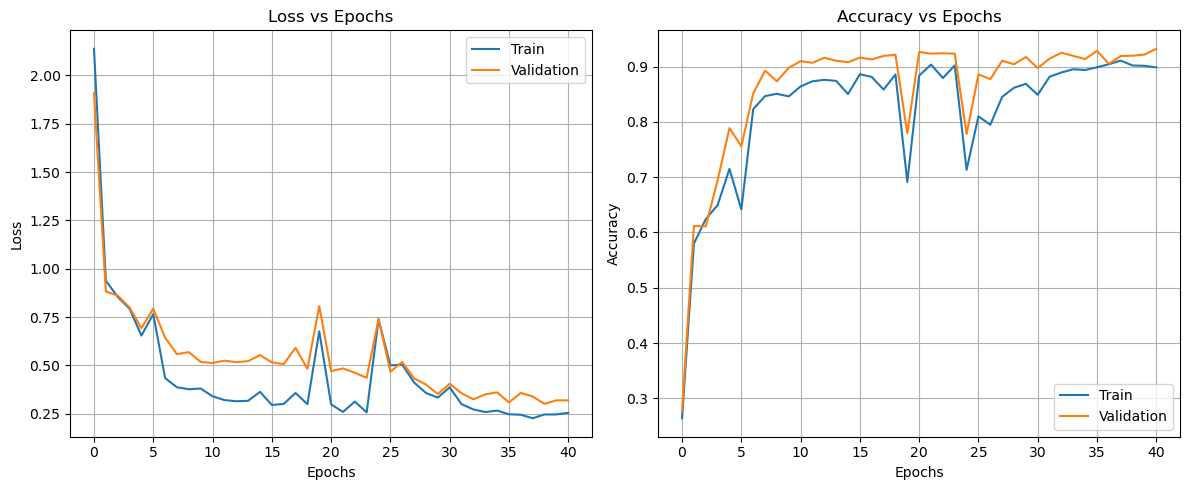

In [36]:
# plot accuracy and loss
start_offset = 100
def plot_acc_loss(train_lss_curve, train_acc_curve, test_lss_curve, test_acc_curve):
    epochs = list(range(0, len(train_lss_curve)))
    # Plotting
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_lss_curve, label='Train')
    plt.plot(epochs, test_lss_curve, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.grid(True)
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_curve, label='Train')
    plt.plot(epochs, test_acc_curve, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_acc_loss(train_lss_curve, train_acc_curve, val_lss_curve, val_acc_curve)

## Model evaluation

After having created and trained our model, we now need to look for appropriate ways to evaluate it. As we have seen abvove our data is relatively unbalanced. So choosing the average accuracy would be not very informative at all. 

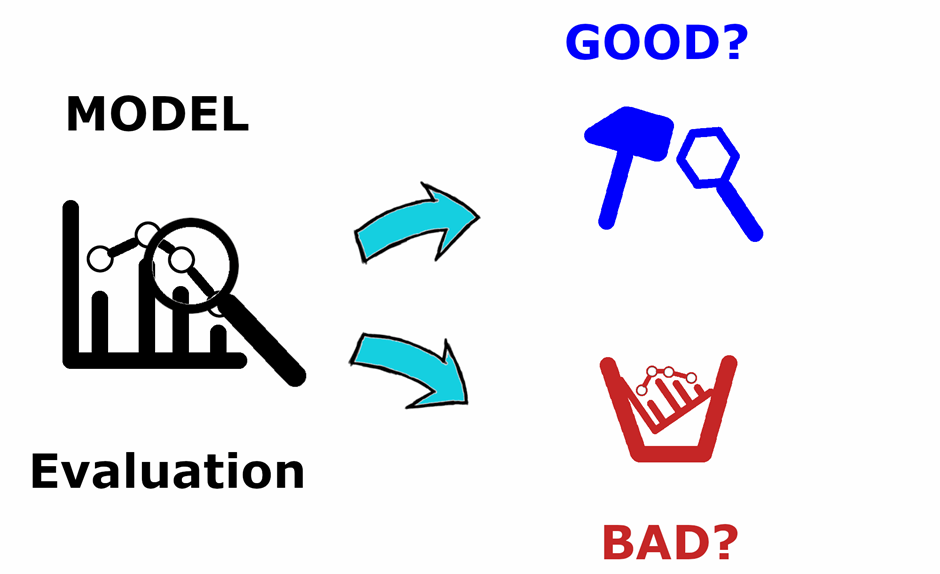


We choose the following metrics to evaluate our performance on an imbalanced dataset:

\begin{align}
precision = (tp/(tp+fp))
\end{align}

The precision shows the ratio of the true positive cases to all cases classified as positive.

\begin{align}
recall = (tp/(tp+fn))
\end{align}


The precision shows the ratio of the true positive cases to all positive cases.


\begin{align}
f1\_score = (2*tp/(2*tp+fp+fn))
\end{align}

The f1-score calculates the harmonic mean between precision and recall.


Additionally we calculate the ROC-AUC score.

In [37]:
## prediction
with torch.no_grad():
    logits      = trained_model(dataset.x, dataset.edge_index)
    output      = logits.argmax(1)

In [38]:
### calculate evaluation metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score


### selecting the test data
test_mask  = dataset['test_mask'].cpu().detach().numpy()

true_labels = labels[test_mask]
pred_labels = output[test_mask].cpu().detach().numpy()
pred_logits = torch.nn.functional.softmax(logits[test_mask], dim=1).cpu().detach().numpy()

## precision
precision = precision_score(true_labels, pred_labels, average = "macro")
print(f"The precision score is {precision}")

## recall
recall = recall_score(true_labels, pred_labels, average = "macro")
print(f"The recall score is {recall}")

## f1 score
f1 = f1_score(true_labels, pred_labels, average = "macro")
print(f"The f1_score score is {f1}")

## auc-roc curve
auc_ovr = roc_auc_score(true_labels, pred_logits, multi_class = 'ovr', average = None)
print(f'ROC AUC score - "one-vs-rest": {auc_ovr}')

The precision score is 0.9473623868461416
The recall score is 0.9492158173731878
The f1_score score is 0.9480793638683578
ROC AUC score - "one-vs-rest": [1.         0.99767618 0.99202202 0.9915817  0.9965946 ]


[[1.         0.         0.         0.         0.        ]
 [0.00135318 0.97834912 0.0202977  0.         0.        ]
 [0.         0.06359946 0.91474966 0.02165088 0.        ]
 [0.         0.         0.0473613  0.8985115  0.0541272 ]
 [0.         0.         0.         0.0455312  0.9544688 ]]


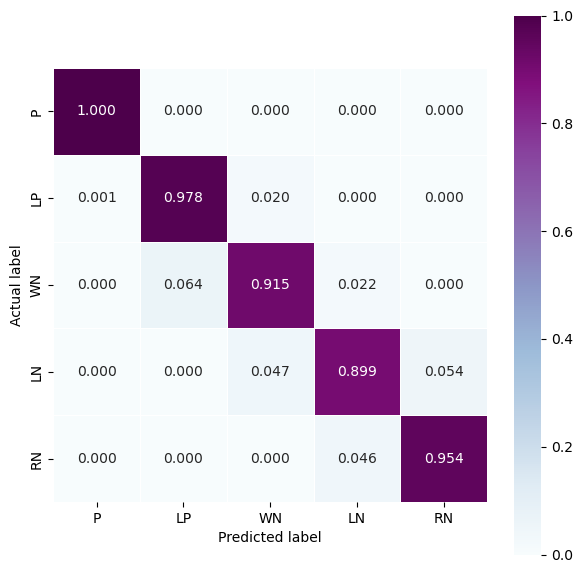

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

classes     = ['P', 'LP', 'WN', 'LN', 'RN']
cm = confusion_matrix(true_labels, pred_labels, normalize='true')
print(cm)

plt.figure(figsize=(7,7))
sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu', xticklabels = classes, yticklabels = classes)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

# Explainable AI and gene ranking

Explainable AI (XAI) encompasses methods and techniques designed to make AI systems' decision-making processes transparent and understandable to humans. This transparency is crucial for trust, accountability, compliance with regulations, and improving AI models. XAI methods are divided into intrinsic explainability, where models like linear regression and decision trees are inherently interpretable, and post-hoc explainability, which provides insights into complex models using techniques like feature importance, LIME, and SHAP. Despite challenges in balancing accuracy and interpretability, XAI aims to make AI technologies more trustworthy and ethically sound, ensuring their responsible integration into various high-stakes domains.

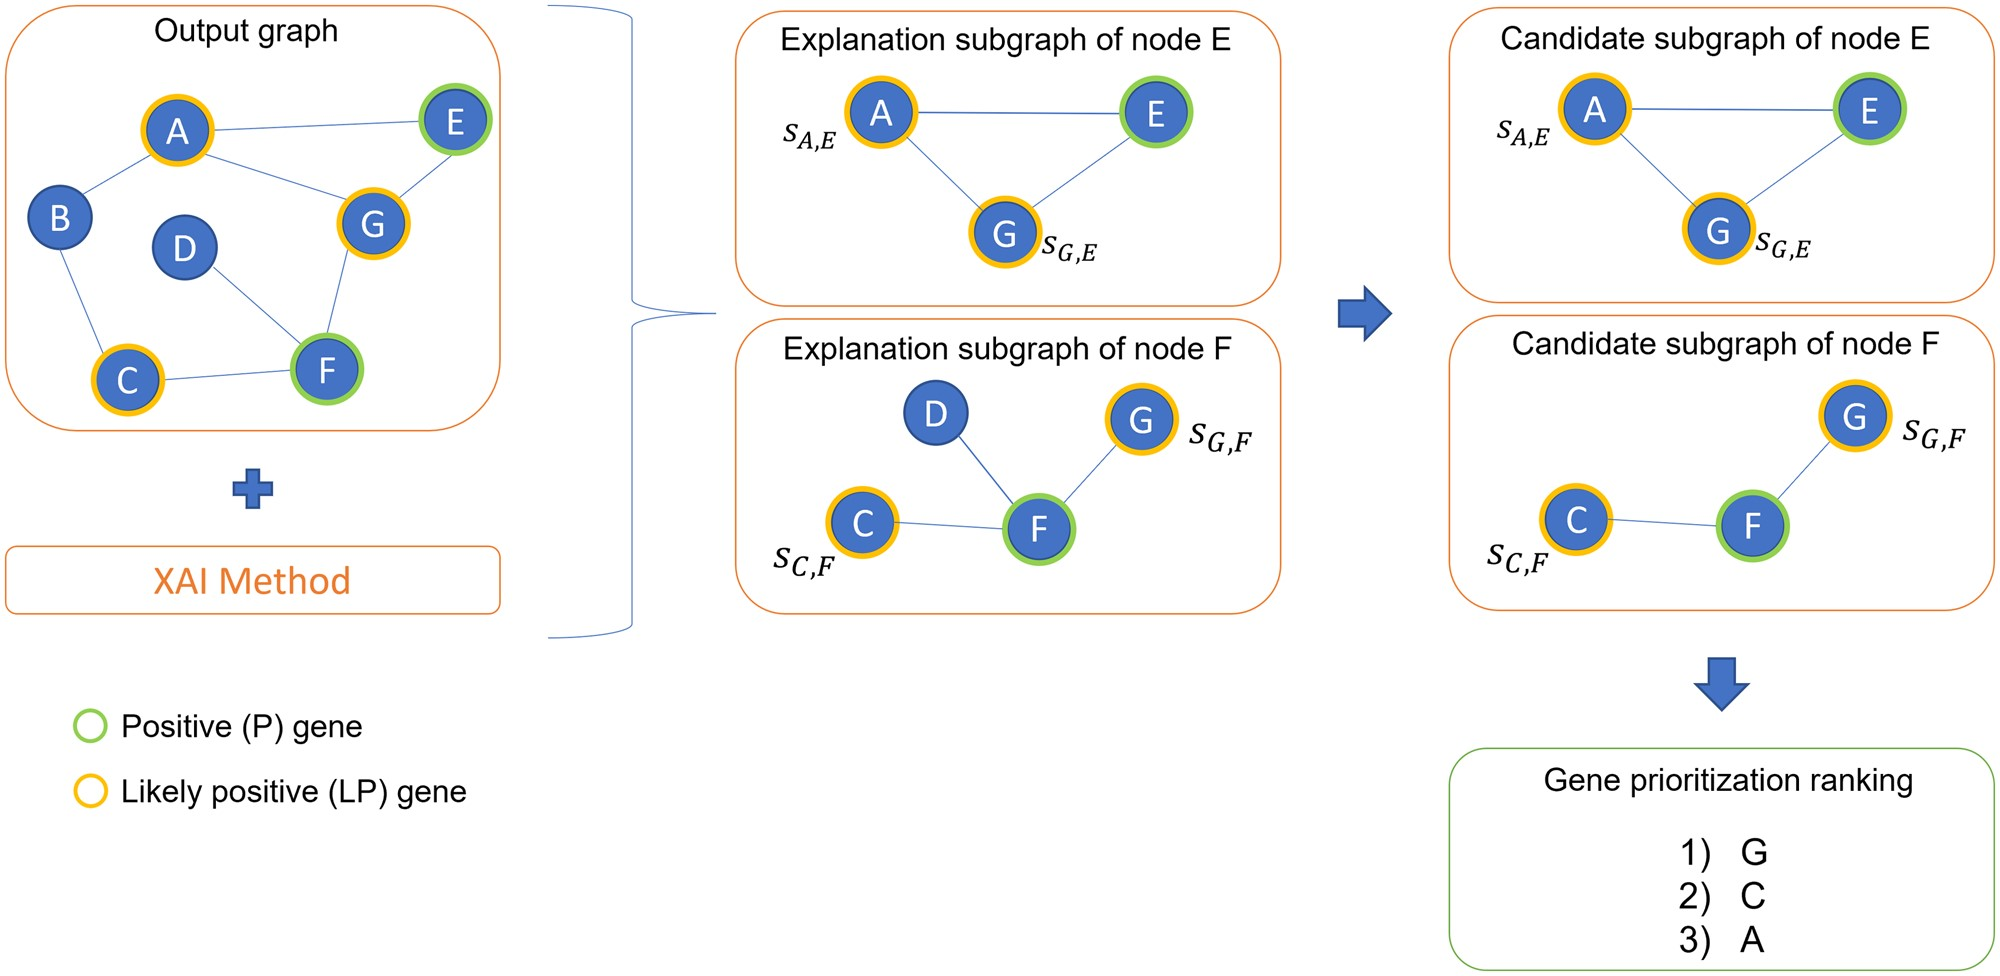

Graphical representations of the XGDAG prioritization mechanism. The output graph from the GNN is fed into an XAI method. For each P gene, we generate an explanation subgraph. This contains the nodes that were influential for the prediction of the node as P. We pool the subgraph by filtering out non-LP nodes, obtaining a final candidate subgraph. sij is the importance score assigned by a given explanation method to i for the prediction of node j. Assuming the cumulative importance score for node C to be greater than the one of node A (SC > SA), we obtain the gene raking in the picture, with G as the top-ranked node because it appears in two candidate subgraphs.




## GNNExplainer

GNNExplainer is an innovative method for providing interpretability to Graph Neural Networks (GNNs), a class of models used for analyzing graph-structured data. As an explainable AI (XAI) technique, GNNExplainer identifies the critical subgraphs, node features, and edge features that contribute most significantly to a GNN's predictions. By producing interpretable explanations for individual predictions, GNNExplainer allows users to understand how specific graph elements influence the model's output. GNNExplainer therefor enhances the usability and reliability of GNNs by making their decision-making processes more transparent and comprehensible.


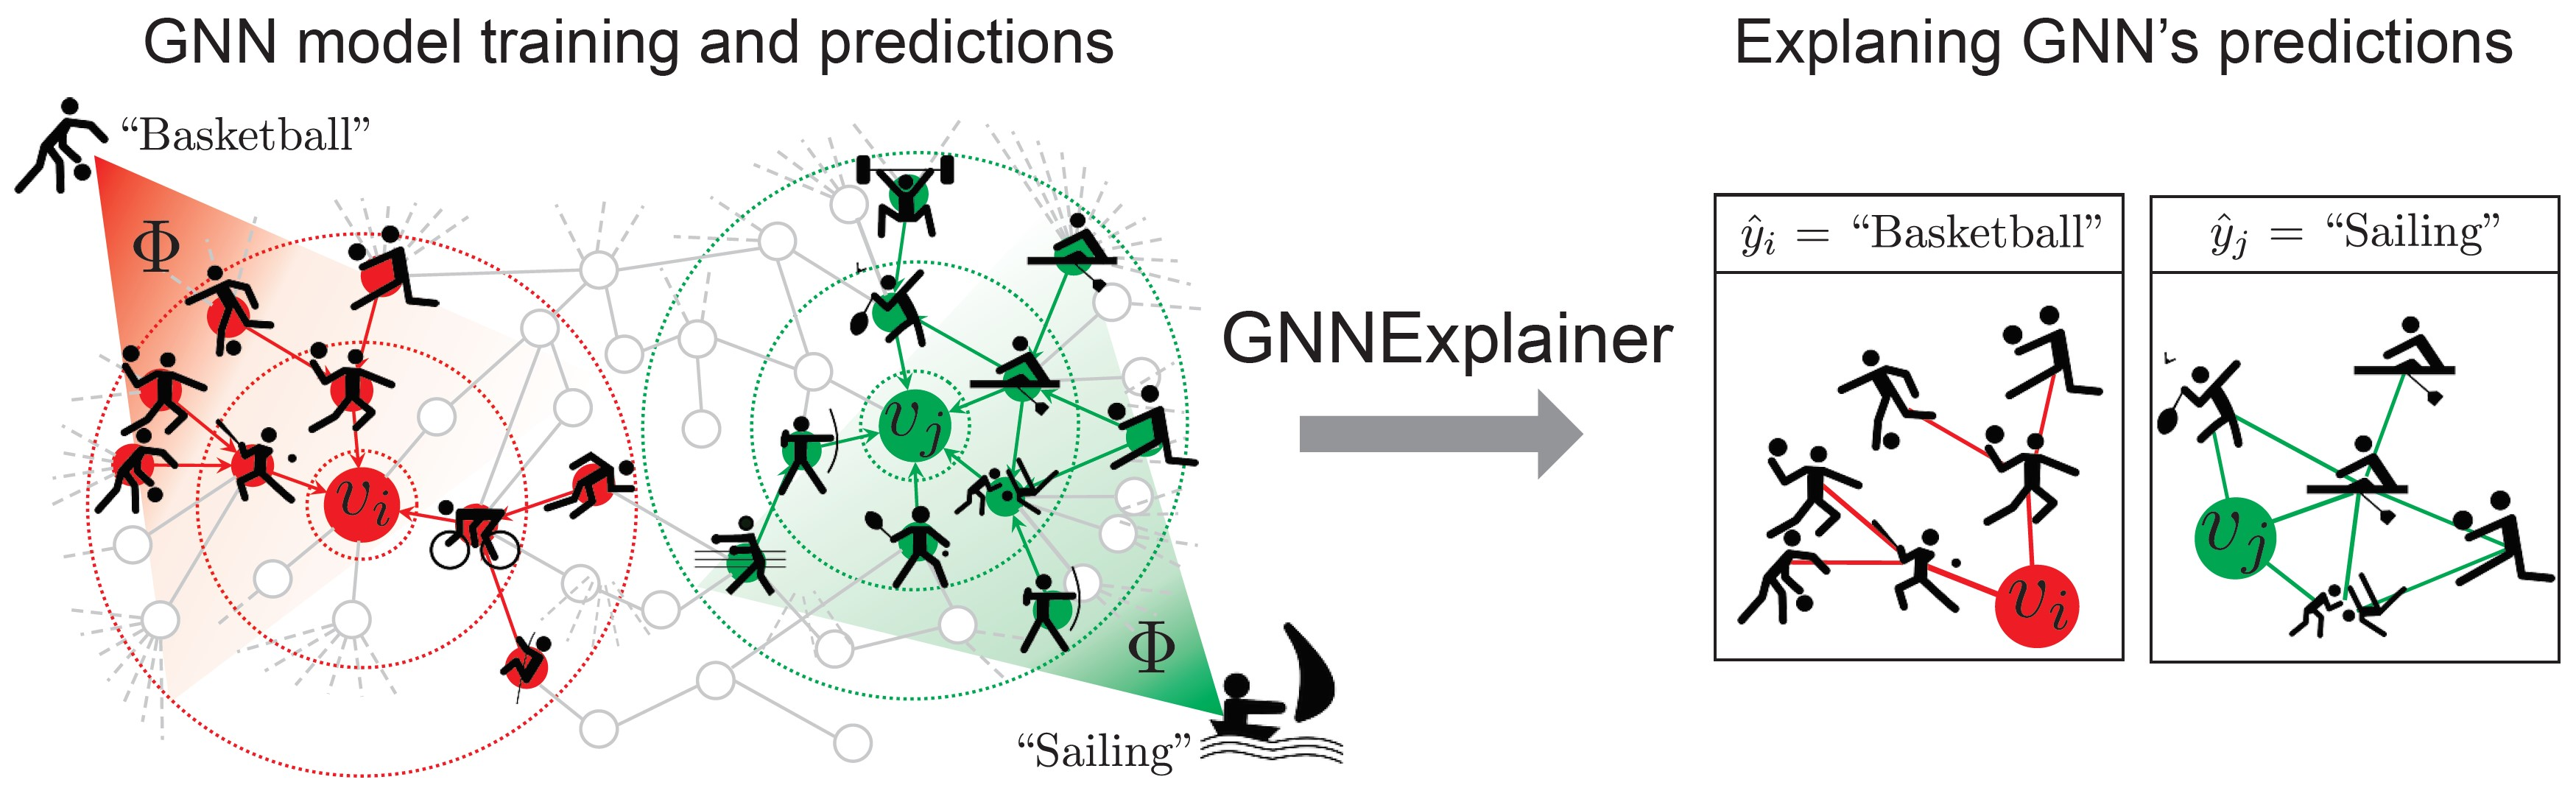



It's main objective is to maximize the multual information shared by the prediction of the underlying network on the whole Graph and the prediction on the subgraph. For a graph G = (V, E, X) with vertixes V, edges E and node information X this means: 


We have a computational Graph:
\begin{align}
G_{c}(V): A_{c}(V) \in \{0,1\}^{n*n}, X_{c}(V) 
\end{align}

with a subset of the Graph:
\begin{align}
G_{s} \subset G_{c}
\end{align}


and a subset of the Features F:
\begin{align}
X_{s}^{F} \subset X_{c}
\end{align}

the baseline GNN model $\theta$ now learns:
\begin{align}
P_{\theta}(Y|G_{c}, X_{c})
\end{align}
where Y is a random variable $y \in \{0, ..., c\}$ and predicts:
\begin{align}
y' = \theta (G_{c}(V),X_{c}(V))
\end{align}


**GNNExplainer now creates predicitons** $y'$ **as** $G_{s}, X_{s}^{F}$ **in a way to maximize the multual information:**

\begin{align}
Max_{G_{s}, F}(MI(Y, (G_{s}, X_{s}^{F})))
\end{align}





In [40]:
### create prediction on full graph
trained_model.to(device)
trained_model.eval()
logits = trained_model(dataset.x, dataset.edge_index)
predictions = logits.argmax(1)

In [41]:
"""
since we don't want to wait forever, we limit us to the explanation of 1 positive node.
"""
import torch_geometric
from torch_geometric.explain import Explainer, GNNExplainer
import itertools

def predict_candidate_genes_gnn_explainer(model, dataset, predictions, explanation_nodes_ratio=1, \
                                          masks_for_seed=10, G=None, num_pos='all'):
    x           = dataset.x
    labels      = dataset.y
    edge_index  = dataset.edge_index

    ranking         = {}
    candidates      = {}
    nodes_with_idxs = {}
    subg_numnodes_d = {}

    nodes_names = list(G.nodes)
    
    i = 0
    for node in G:
        if labels[i] == 0:
            nodes_with_idxs[node] = i
        i += 1
    
    print('[+]', len(nodes_with_idxs), 'positive nodes found in the graph')

    sub_nodes_with_idxs = dict(itertools.islice(nodes_with_idxs.items(), 1))
    # Get the subgraphs of a positive nodes
    for node in sub_nodes_with_idxs:
        idx = sub_nodes_with_idxs[node]
        print("Node idx: {}".format(idx))
        subg_nodes, subg_edge_index, subg_mapping, subg_edge_mask = torch_geometric.utils.k_hop_subgraph(idx, 1, edge_index)
        if idx not in subg_numnodes_d:
            subg_numnodes_d[idx] = [len(subg_nodes), subg_edge_index.shape[1]]

    # Get explanations of all the positive genes
    nodes_explained = 0
    num_pos = len(sub_nodes_with_idxs)
    print(sub_nodes_with_idxs, num_pos)
    for node in tqdm(sub_nodes_with_idxs):
        idx = sub_nodes_with_idxs[node]

        candidates[node] = {}

        mean_mask = torch.zeros(edge_index.shape[1]).to('cpu')

        for i in range(masks_for_seed):
            print("seed run: {}".format(i))
            explainer = Explainer(model=model, algorithm=GNNExplainer(epochs=500), explanation_type='model', node_mask_type='attributes', \
                              edge_mask_type='object', model_config=dict(mode='multiclass_classification', task_level='node', return_type='log_probs',),)

            explanation = explainer(x, edge_index, index=idx)
            mean_mask += explanation.edge_mask.to('cpu')

        mean_mask = torch.div(mean_mask, masks_for_seed)
        print("Shape of mean mask: {}".format(mean_mask.shape))
        num_nodes = int(round(subg_numnodes_d[idx][0]*explanation_nodes_ratio))
        print("Number of nodes: {}".format(num_nodes))
        values, indices = torch.topk(mean_mask, subg_numnodes_d[idx][1])
        print(len(values), len(indices))
        print("Number of selected edges: {}".format(len(indices)))

        seen_genes = set()

        for i in range(len(indices)):
            src     = edge_index[0][indices[i]]
            trgt    = edge_index[1][indices[i]]

            src_name    = nodes_names[src]
            trgt_name   = nodes_names[trgt]

            src_pred    = predictions[src]
            trgt_pred   = predictions[trgt]

            # if gene has not been seen and it is not the explained node
            # we add it to the seen genes set
            if src_name != node:
                seen_genes.add(src_name)
            if trgt_name != node:
                seen_genes.add(trgt_name)

            if src_pred == 1: # LP
                if src_name not in candidates[node]:
                    candidates[node][src_name] = values[i]
                else:
                    candidates[node][src_name] += values[i]

            if trgt_pred == 1: # LP
                if trgt_name not in candidates[node]:
                    candidates[node][trgt_name] = values[i]
                else:
                    candidates[node][trgt_name] += values[i]
            
            # when the seen geens set reaches the num_nodes threshold
            # break the loop
            if len(seen_genes) >= num_nodes:
                break

    for seed in candidates:
        for candidate in candidates[seed]:
            if candidate not in ranking:
                ranking[candidate] = [1, candidates[seed][candidate].item()]
            else:
                ranking[candidate][0] += 1
                ranking[candidate][1] += candidates[seed][candidate].item()
    
    sorted_ranking  = sorted(ranking, key=lambda x: (ranking[x][0], ranking[x][1]), reverse=True)

    return sorted_ranking, subg_nodes

s_rankings, subg_nodes = predict_candidate_genes_gnn_explainer(trained_model, dataset, predictions, G=G, masks_for_seed=10)

[+] 1025 positive nodes found in the graph
Node idx: 0
{'MAP2K4': 0} 1


  0%|                                                                                                                                                                                | 0/1 [00:00<?, ?it/s]

seed run: 0
seed run: 1
seed run: 2
seed run: 3
seed run: 4
seed run: 5
seed run: 6
seed run: 7
seed run: 8
seed run: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:38<00:00, 98.69s/it]

Shape of mean mask: torch.Size([1357864])
Number of nodes: 53
478 478
Number of selected edges: 478


In [42]:
s_rankings, len(s_rankings)

(['AGO2',
  'CYLC2',
  'FBP2',
  'MAP3K8',
  'APP',
  'MAP3K11',
  'MAPK8IP3',
  'BLNK',
  'MAPK10',
  'TRIM25',
  'MAP2K6',
  'APEX1',
  'ZDHHC17',
  'PLEKHA4',
  'MAP3K3',
  'MAP3K4',
  'RBBP8',
  'LRRK2',
  'MAP3K5',
  'UBC',
  'ARRB2',
  'GEMIN5',
  'MAPK14',
  'HSCB',
  'VASP',
  'SPAG9',
  'FLNC',
  'NBR1',
  'ARRB1',
  'MAPK9',
  'MAPK1',
  'ITCH',
  'STX17',
  'MAPK8',
  'CDC5L'],
 35)

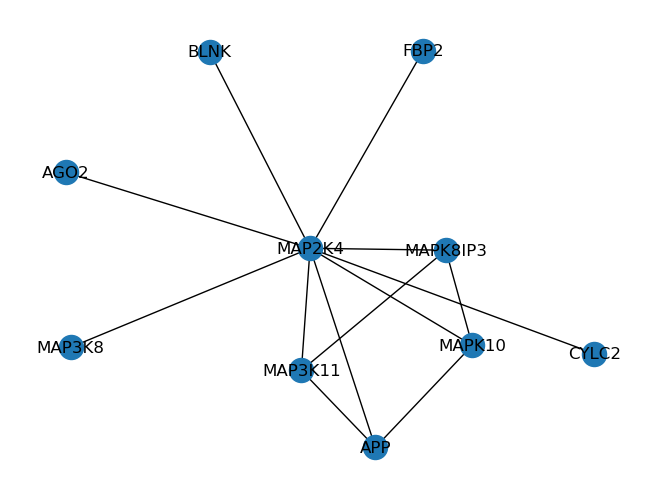

In [43]:
s_rankings_explained_node = ["MAP2K4"] + s_rankings
s_rankings_draw = s_rankings_explained_node[:10]
new_nodes = []
for enum, n in enumerate(G.nodes(data=True)):
        if n[0] not in s_rankings_draw: continue
        new_nodes.append(n[0])

k = G.subgraph(new_nodes)
pos = nx.spring_layout(k)
nx.draw(k, pos=pos, with_labels = True)
plt.show()

# Alternative methods

Instead of just using GNNExplainer we could also have used GraphSVX and SubgraphX in combination with GNNExplainer. Creating an ensemble here might have the benefit of creating more stable and certain results. This is of course quite time-consuming, so we will have to stick with just focusing on using GNNExplainer.


## GraphSVX

GraphSVX is a method for Explainable AI (XAI) designed specifically to explain predictions made by Graph Neural Networks (GNNs). GNNs are powerful models used for tasks involving graph-structured data, such as social networks, molecular structures, and recommendation systems. However, like other complex machine learning models, GNNs are often seen as black boxes due to their lack of interpretability. GraphSVX aims to address this by providing insights into how GNNs make their predictions.

GraphSVX makes use of Shapely values to explain the importance of subgraphs. It follows the following steps: 

1. **Sampling Subgraphs**: Randomly sample subgraphs from the original graph to consider various local structures around the node being explained. This helps in capturing the influence of different parts of the graph on the prediction.

1. **Perturbation**: Perturb the features of nodes and edges in these subgraphs to observe the changes in the model’s output. This is analogous to assessing the contribution of individual features in traditional tabular data.

1. **Model Evaluation**: Evaluate the GNN on these perturbed subgraphs to gather data on how each feature (node or edge) affects the prediction.

1. **Shapley Value Approximation**: Use the gathered data to approximate Shapley values for each node and edge in the subgraph. These values indicate the importance of each element in the graph to the model's prediction.

1. **Aggregation**: Aggregate the Shapley values from multiple subgraphs to get a robust estimate of the importance of each node and edge in the original graph.



## SubgraphX

SubgraphX is another method for Explainable AI (XAI) tailored to graph neural networks (GNNs). It focuses on providing explanations for GNN predictions by identifying and evaluating subgraphs that are most influential in the decision-making process. Unlike methods that explain individual features, SubgraphX seeks to understand the contributions of entire subgraphs to the model’s predictions.

1. **Node Selection**: Select the target node for which the explanation is to be generated. This is typically the node for which the GNN has made a prediction.

1. **Initial Subgraph Generation**: Generate an initial set of subgraphs around the target node. These subgraphs can vary in size and complexity, capturing different parts of the graph's local structure.

1. **Monte Carlo Tree Search (MCTS)**: Construct a search tree where each node represents a subgraph. The root is the initial subgraph and the child nodes are created by adding or removing nodes or edges. Next we try to find the importance of each subgraph by running GraphSage on them and observing the change in the prediction. Rewards are then calculated based on the influence of each subgraph on the prediction. 

1. **Importance Scoring**: Assign importance scores to subgraphs based on the results of the MCTS. These scores reflect the contribution of each subgraph to the GNN’s prediction.

1. **Explanation Generation**: Generate explanations by highlighting the most important subgraphs and their components (nodes and edges). This provides insights into which parts of the graph are driving the model’s decisions.
